### remember to change model saving path!!!

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss, TverskyLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
from hybrid_model_v3 import HybridSegModel

/home/twszbak764/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
import wandb
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s960068sss (s960068sss-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class Ge_Benq_add_inference_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size, training = True):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
        self.training = training
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]
        dataset = self.df["dataset"][idx]
        mask_type = self.df["mask_type"][idx]
        from_inference = self.df["inference"][idx]
        if from_inference:
            inference_from_which_dataset = self.df["from_folder"][idx]
        
        if dataset == "ge":
            from_dataset = 1
        elif dataset == "benq":
            from_dataset = 2

        if mask_type == "nodule":
            mask_type = 1
        elif mask_type == "gland":
            mask_type = 2

        if from_inference == False:
            if dataset == "benq":
                from_folder = "../gland_data"
            elif dataset == "ge":
                if mask_type == 1:
                    from_folder = "../ge_data/nodule"
                else:
                    from_folder = "../ge_data/gland"
            
            image_path = f"{from_folder}/images/{image_name}"
            mask_path = f"{from_folder}/masks/{mask_name}"
        else:
            if inference_from_which_dataset == "ge_gland":
                image_path = f"../ge_data/gland/images/{image_name}"
                mask_path = f"../ge_data/gland/from_scratch_inference_masks_all_v1/nodule/{mask_name}"
            elif inference_from_which_dataset == "ge_video":
                image_path = f"../ge_data/from_videos/crop_images/{image_name}"
                mask_path = f"../ge_data/from_videos/inference_mask_from_scratch_v2_aug_space(0.9)_weight_decay(1e-5)/{mask_name}"
            else:
                print("not find!!")

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()
        if torch.sum(mask_tensor) == 0:
            # print("nothing")
            return [None]
        return image_tensor, mask_tensor, from_dataset, mask_type

In [5]:
image_size = 128
batch_size = 256
def train_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    p = 0.9
    
    # if(random.random() < p):
    #     jitter = T.ColorJitter(brightness = 0.5, contrast = 0.25)
    #     image = jitter(image)
    # if(random.random() < p):
    #     transform = T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    #     image = transform(image)  # image must be a PIL image
    if(random.random() < p):
        # angle = random.uniform(-10, 10)  # 旋轉角度從 ±10 度
        angle = 0.0
        max_dx = 0.05  # 水平平移比例
        max_dy = 0.3  # 垂直平移比例
        translate_x = random.uniform(-max_dx, max_dx) * image.size[0]
        translate_y = random.uniform(-max_dy, max_dy) * image.size[1]
        translate = (int(translate_x), int(translate_y))
        scale = random.uniform(0.9, 1.6)  # 尺度縮放 ±5%
        # scale = 1.0
        # shear = [random.uniform(-5, 5), random.uniform(-5, 5)]  # 小幅剪切
        shear=[0.0, 0.0]
        image = F.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)
        mask = F.affine(mask, angle=angle, translate=translate, scale=scale, shear=shear)

        
    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def custom_collate_fn(batch):
    # print(batch)
    filtered_batch = [item for item in batch if item[0] is not None]
    if len(filtered_batch) == 0:
        return [None, None, None, None]
    return torch.utils.data.dataloader.default_collate(filtered_batch)
train_dataset = Ge_Benq_add_inference_Dataset("../ge_benq_data/ge(nodule_gland)_benq(gland)_train_add_inference_v2_2.csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn=custom_collate_fn)

test_dataset = Ge_Benq_add_inference_Dataset("../ge_benq_data/ge(nodule_gland)_benq(gland)_test_add_inference_v2_2.csv", transform = test_augmentation, image_size = image_size, training = False)
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = False, collate_fn=custom_collate_fn)

image, mask, from_dataset, mask_type = next(iter(train_dataloader))

In [6]:
mask.shape

torch.Size([232, 1, 128, 128])

In [7]:
mask_type

tensor([2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1,
        1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
        2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1,
        2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1,
        1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1,
        2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1,
        1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1])

In [8]:
print(len(train_dataset), len(test_dataset))

863 229


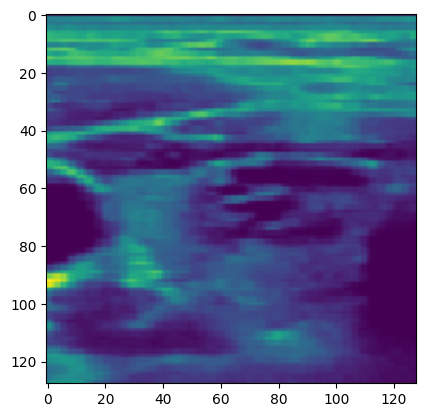

In [9]:
plt.imshow(image[18][0])

In [10]:
def train(dataloader, model, optimizer, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0

    total_ge_nodule_IOU = 0
    total_ge_gland_IOU = 0
    total_benq_gland_IOU = 0
    
    total_ge_nodule_DICE = 0
    total_ge_gland_DICE = 0
    total_benq_gland_DICE = 0
    
    model.train()
    model.to(device)
    
    count = 0
    for image, mask, from_dataset, mask_type in tqdm(dataloader):
        if image == None:
            continue
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        
        nodule_output = outputs[:, 0:1, :, :]
        gland_output = outputs[:, 1:2, :, :]

        # get output
        ge_nodule_output = nodule_output[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_output = gland_output[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_output = gland_output[(from_dataset == 2) & (mask_type == 2)]

        # get len
        ge_nodule_len = ge_nodule_output.shape[0]
        ge_gland_len = ge_gland_output.shape[0]
        benq_gland_len = benq_gland_output.shape[0]

        if ge_nodule_len == 0 or ge_gland_len == 0 or benq_gland_len == 0:
            continue

        nodule_ratio = ge_nodule_len / (ge_nodule_len + ge_gland_len + benq_gland_len)
        gland_ratio = (ge_gland_len + benq_gland_len) / (ge_nodule_len + ge_gland_len + benq_gland_len)
        
        ge_gland_ratio = ge_gland_len / (ge_gland_len + benq_gland_len)
        benq_gland_ratio = benq_gland_len / (ge_gland_len + benq_gland_len)
        
        # get mask
        ge_nodule_mask = mask[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_mask = mask[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_mask = mask[(from_dataset == 2) & (mask_type == 2)]
        
        #get loss
        ge_nodule_loss = loss_fn(ge_nodule_output, ge_nodule_mask)
        ge_gland_loss = loss_fn(ge_gland_output, ge_gland_mask)
        benq_gland_loss = loss_fn(benq_gland_output, benq_gland_mask)

        nodule_loss = ge_nodule_loss
        gland_loss = (ge_gland_loss * ge_gland_ratio + benq_gland_loss * benq_gland_ratio)
        loss = (nodule_loss * nodule_ratio + gland_loss * gland_ratio)
        
        # get IOU
        ge_nodule_IOU = IOU_score(ge_nodule_output, ge_nodule_mask)
        ge_gland_IOU = IOU_score(ge_gland_output, ge_gland_mask)
        benq_gland_IOU = IOU_score(benq_gland_output, benq_gland_mask)

        nodule_IOU = ge_nodule_IOU
        gland_IOU = (ge_gland_IOU * ge_gland_ratio + benq_gland_IOU * benq_gland_ratio)
        IOU = (nodule_IOU * nodule_ratio + gland_IOU * gland_ratio)

        # get DICE
        dice_loss = DiceLoss()
        
        ge_nodule_DICE = 1 - dice_loss(ge_nodule_output, ge_nodule_mask)
        ge_gland_DICE = 1 - dice_loss(ge_gland_output, ge_gland_mask)
        benq_gland_DICE = 1 - dice_loss(benq_gland_output, benq_gland_mask)

        nodule_DICE = ge_nodule_DICE
        gland_DICE = (ge_gland_DICE * ge_gland_ratio + benq_gland_DICE * benq_gland_ratio)
        DICE = (nodule_DICE * nodule_ratio + gland_DICE * gland_ratio)

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()

        total_ge_nodule_IOU += ge_nodule_IOU
        total_ge_gland_IOU += ge_gland_IOU
        total_benq_gland_IOU += benq_gland_IOU

        total_ge_nodule_DICE += ge_nodule_DICE
        total_ge_gland_DICE += ge_gland_DICE
        total_benq_gland_DICE += benq_gland_DICE
        count+=1

    return total_loss/count, total_IOU/count, total_DICE/count, total_ge_nodule_IOU/count, total_ge_gland_IOU/count, total_benq_gland_IOU/count, total_ge_nodule_DICE/count, total_ge_gland_DICE/count, total_benq_gland_DICE/count


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0

    ge_nodule_IOU = 0
    ge_gland_IOU = 0
    benq_gland_IOU = 0

    ge_nodule_DICE = 0
    ge_gland_DICE = 0
    benq_gland_DICE = 0

    ge_nodule_count = 0
    ge_gland_count = 0
    benq_gland_count = 0
    
    model.eval()
    model.to(device)
    
    for image, mask, from_dataset, mask_type in tqdm(dataloader):
        if image == None:
            continue
            
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        nodule_output = outputs[:, 0:1, :, :]
        gland_output = outputs[:, 1:2, :, :]

        ge_nodule_output = nodule_output[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_output = gland_output[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_output = gland_output[(from_dataset == 2) & (mask_type == 2)]

        ge_nodule_mask = mask[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_mask = mask[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_mask = mask[(from_dataset == 2) & (mask_type == 2)]
        
        if from_dataset[0] == 1 and mask_type[0] == 1:
            loss = loss_fn(ge_nodule_output, ge_nodule_mask)
            IOU = IOU_score(ge_nodule_output, ge_nodule_mask)
            dice_loss = DiceLoss()
            DICE = 1 - dice_loss(ge_nodule_output, ge_nodule_mask)

            ge_nodule_IOU += IOU.item()
            ge_nodule_DICE += DICE.item()
            total_loss += loss.item()
            total_IOU += IOU.item()
            total_DICE += DICE.item()
            ge_nodule_count += 1
        elif from_dataset[0] == 1 and mask_type[0] == 2:
            loss = loss_fn(ge_gland_output, ge_gland_mask)
            IOU = IOU_score(ge_gland_output, ge_gland_mask)
            dice_loss = DiceLoss()
            DICE = 1 - dice_loss(ge_gland_output, ge_gland_mask)

            ge_gland_IOU += IOU.item()
            ge_gland_DICE += DICE.item()
            total_loss += loss.item()
            total_IOU += IOU.item()
            total_DICE += DICE.item()
            ge_gland_count += 1
        elif from_dataset[0] == 2 and mask_type[0] == 2:
            loss = loss_fn(benq_gland_output, benq_gland_mask)
            IOU = IOU_score(benq_gland_output, benq_gland_mask)
            dice_loss = DiceLoss()
            DICE = 1 - dice_loss(benq_gland_output, benq_gland_mask)
            
            benq_gland_IOU += IOU.item()
            benq_gland_DICE += DICE.item()
            total_loss += loss.item()
            total_IOU += IOU.item()
            total_DICE += DICE.item()
            benq_gland_count += 1
    count = (ge_nodule_count + ge_gland_count + benq_gland_count)
    return total_loss/count , total_IOU/count, total_DICE/count, ge_nodule_IOU/ge_nodule_count, ge_gland_IOU/ge_gland_count, benq_gland_IOU/benq_gland_count, ge_nodule_DICE/ge_nodule_count, ge_gland_DICE/ge_gland_count, benq_gland_DICE/benq_gland_count

    

In [11]:

# inference_name = "models/Phase 1/Hybrid_crop_DDTI_standardization_aug_affine(0.5)_for_gland"
model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3, dropout_rate = 0.0)
# checkpoint = torch.load(f"{inference_name}/best_checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

In [12]:
# # freeze encoder
# for param in model.backbone.parameters():
#     param.requires_grad = False

In [13]:

epochs = 500
lr = 0.01
loss_fn = StructureLoss()
# loss_fn = TverskyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = 1e-4)
# optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [14]:

project = "thyroid_ge_benq_from_scratch"
name = "hybrid_model_ge(nodule_gland_inference)_benq(gland)_from_scratch_v3_2_aug_space(0.9)_weight_decay(1e-4)"
# name = "test"

wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        "augmentation" : "space(0.9)",
        "weight_decay":1e-4
    }
)

In [15]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.01, epochs : 500, batch size : 256


In [16]:
max_IOU = -1
max_nodule_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train, ge_nodule_IOU_train, ge_gland_IOU_train, benq_gland_IOU_train, ge_nodule_DICE_train, ge_gland_DICE_train, benq_gland_DICE_train = train(train_dataloader, model, optimizer, loss_fn, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val, ge_nodule_IOU_val, ge_gland_IOU_val, benq_gland_IOU_val, ge_nodule_DICE_val, ge_gland_DICE_val, benq_gland_DICE_val = val(test_dataloader, model, loss_fn, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/from_scratch/ge_benq_inference/{name}/"
        os.makedirs(folder, exist_ok = True)
        torch.save(checkpoint, f"{folder}/best_checkpoint.pth")

    if max_nodule_IOU < ge_nodule_IOU_val:
        max_nodule_IOU = ge_nodule_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/from_scratch/ge_benq_inference/{name}/"
        os.makedirs(folder, exist_ok = True)
        torch.save(checkpoint, f"{folder}/nodule_best_checkpoint.pth")
        
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        "train_ge_nodule_IOU" : ge_nodule_IOU_train,
        "train_ge_nodule_DICE" : ge_nodule_DICE_train,
        "train_ge_gland_IOU" : ge_gland_IOU_train,
        "train_ge_gland_DICE" : ge_gland_DICE_train,
        "train_benq_gland_IOU" : benq_gland_IOU_train,
        "train_benq_gland_DICE" : benq_gland_DICE_train,
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,
        "val_ge_nodule_IOU" : ge_nodule_IOU_val,
        "val_ge_nodule_DICE" : ge_nodule_DICE_val,
        "val_ge_gland_IOU" : ge_gland_IOU_val,
        "val_ge_gland_DICE" : ge_gland_DICE_val,
        "val_benq_gland_IOU" : benq_gland_IOU_val,
        "val_benq_gland_DICE" : benq_gland_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
torch.save(checkpoint, f"{folder}/last_checkpoint.pth")
wandb.finish()

epoch : 0


/home/twszbak764/miniconda3/envs/thyroid/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 4/4 [00:13<00:00,  3.37s/it]


train loss : 1.2657987475395203, train IOU : 0.11010937578976154, train DICE : 0.20487364381551743


100%|██████████| 229/229 [00:05<00:00, 42.58it/s]


val loss : 1.6712859056212686, val IOU : 8.900975439311491e-10, val DICE : 0.04368841527688383
epoch : 1


100%|██████████| 4/4 [00:10<00:00,  2.75s/it]


train loss : 1.0125679671764374, train IOU : 0.13962957821786404, train DICE : 0.2922057434916496


100%|██████████| 229/229 [00:04<00:00, 46.59it/s]


val loss : 1.3483529512328332, val IOU : 0.060043584028998266, val DICE : 0.11378632049367886
epoch : 2


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.9076891839504242, train IOU : 0.3247615396976471, train DICE : 0.4008292704820633


100%|██████████| 229/229 [00:04<00:00, 45.96it/s]


val loss : 1.289351185162862, val IOU : 0.092344250801601, val DICE : 0.21149463665605794
epoch : 3


100%|██████████| 4/4 [00:11<00:00,  2.75s/it]


train loss : 0.8119707554578781, train IOU : 0.39497561007738113, train DICE : 0.4950906112790108


100%|██████████| 229/229 [00:04<00:00, 45.92it/s]


val loss : 1.3779141321928814, val IOU : 0.2823102209773479, val DICE : 0.3645835238875765
epoch : 4


100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


train loss : 0.7656184583902359, train IOU : 0.42298050969839096, train DICE : 0.541879415512085


100%|██████████| 229/229 [00:04<00:00, 47.08it/s]


val loss : 1.278215459199867, val IOU : 0.26258958143304395, val DICE : 0.36544850950289254
epoch : 5


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.7129862457513809, train IOU : 0.4544166922569275, train DICE : 0.5783736109733582


100%|██████████| 229/229 [00:04<00:00, 49.92it/s]


val loss : 1.1647216280301411, val IOU : 0.2650522319789032, val DICE : 0.37706892237518774
epoch : 6


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.6902697384357452, train IOU : 0.4659244567155838, train DICE : 0.5964289009571075


100%|██████████| 229/229 [00:04<00:00, 49.69it/s]


val loss : 1.3403247492481964, val IOU : 0.19180519793513823, val DICE : 0.30160302435508884
epoch : 7


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.6596884280443192, train IOU : 0.49507444351911545, train DICE : 0.6258437484502792


100%|██████████| 229/229 [00:04<00:00, 49.78it/s]


val loss : 0.9922176719915987, val IOU : 0.3513830810617138, val DICE : 0.4581281512674659
epoch : 8


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.6533296555280685, train IOU : 0.49870046228170395, train DICE : 0.6292256712913513


100%|██████████| 229/229 [00:04<00:00, 49.93it/s]


val loss : 0.798803446569828, val IOU : 0.42750736000486694, val DICE : 0.5318046103824269
epoch : 9


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.6261697709560394, train IOU : 0.5155841782689095, train DICE : 0.6425881236791611


100%|██████████| 229/229 [00:04<00:00, 49.93it/s]


val loss : 0.8471048108556054, val IOU : 0.40322260764175394, val DICE : 0.5203555882579148
epoch : 10


100%|██████████| 4/4 [00:10<00:00,  2.70s/it]


train loss : 0.6009725332260132, train IOU : 0.5395346730947495, train DICE : 0.6685443818569183


100%|██████████| 229/229 [00:04<00:00, 48.18it/s]


val loss : 0.756160931755798, val IOU : 0.48731282547682697, val DICE : 0.5821465931155465
epoch : 11


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.5992828756570816, train IOU : 0.5416388064622879, train DICE : 0.6661595553159714


100%|██████████| 229/229 [00:04<00:00, 48.68it/s]


val loss : 0.7610613976163093, val IOU : 0.4589838074546704, val DICE : 0.5726793706417084
epoch : 12


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.5938539057970047, train IOU : 0.5412960797548294, train DICE : 0.6660149544477463


100%|██████████| 229/229 [00:04<00:00, 50.05it/s]


val loss : 1.1297932324385402, val IOU : 0.22884424543671023, val DICE : 0.34538474287649595
epoch : 13


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.5673355758190155, train IOU : 0.5622857213020325, train DICE : 0.6961404532194138


100%|██████████| 229/229 [00:04<00:00, 49.72it/s]


val loss : 0.7002192633320586, val IOU : 0.5153562491301474, val DICE : 0.6220214035775926
epoch : 14


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.5557665377855301, train IOU : 0.5675984621047974, train DICE : 0.6947295814752579


100%|██████████| 229/229 [00:04<00:00, 49.71it/s]


val loss : 0.7937250621993133, val IOU : 0.44945920424364144, val DICE : 0.5437492475365148
epoch : 15


100%|██████████| 4/4 [00:10<00:00,  2.69s/it]


train loss : 0.531540647149086, train IOU : 0.582078605890274, train DICE : 0.7086943686008453


100%|██████████| 229/229 [00:05<00:00, 45.01it/s]


val loss : 0.7276402696816608, val IOU : 0.518682182787941, val DICE : 0.6232861987870149
epoch : 16


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.5364609211683273, train IOU : 0.5832993984222412, train DICE : 0.712242528796196


100%|██████████| 229/229 [00:05<00:00, 45.43it/s]


val loss : 0.7429517875566627, val IOU : 0.4849000196297824, val DICE : 0.5896428107011198
epoch : 17


100%|██████████| 4/4 [00:10<00:00,  2.70s/it]


train loss : 0.5093174129724503, train IOU : 0.5990075170993805, train DICE : 0.7313888967037201


100%|██████████| 229/229 [00:04<00:00, 46.48it/s]


val loss : 0.8828880105054739, val IOU : 0.3799722453234474, val DICE : 0.47702234682410655
epoch : 18


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.511486142873764, train IOU : 0.5922082662582397, train DICE : 0.7256322801113129


100%|██████████| 229/229 [00:04<00:00, 46.38it/s]


val loss : 0.8246339649865122, val IOU : 0.438758446919932, val DICE : 0.53162737958359
epoch : 19


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.49594423919916153, train IOU : 0.618760421872139, train DICE : 0.7422819435596466


100%|██████████| 229/229 [00:04<00:00, 47.28it/s]


val loss : 0.8098812320015647, val IOU : 0.4500708362046034, val DICE : 0.533107578754425
epoch : 20


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.4968937262892723, train IOU : 0.6187639385461807, train DICE : 0.7377767711877823


100%|██████████| 229/229 [00:05<00:00, 45.56it/s]


val loss : 0.8400081709177807, val IOU : 0.40991544754102777, val DICE : 0.5153912411193655
epoch : 21


100%|██████████| 4/4 [00:10<00:00,  2.75s/it]


train loss : 0.4527623653411865, train IOU : 0.6463742256164551, train DICE : 0.7618131637573242


100%|██████████| 229/229 [00:05<00:00, 45.57it/s]


val loss : 0.7812611063321432, val IOU : 0.4673689572172, val DICE : 0.5846477849314912
epoch : 22


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.46175429224967957, train IOU : 0.6438767313957214, train DICE : 0.7641207426786423


100%|██████████| 229/229 [00:04<00:00, 46.15it/s]


val loss : 0.7067616501390331, val IOU : 0.5119775572057926, val DICE : 0.6281669997807705
epoch : 23


100%|██████████| 4/4 [00:10<00:00,  2.70s/it]


train loss : 0.46295997500419617, train IOU : 0.639319971203804, train DICE : 0.7605178207159042


100%|██████████| 229/229 [00:04<00:00, 46.13it/s]


val loss : 0.8776970606560659, val IOU : 0.4074134537294442, val DICE : 0.491082911840593
epoch : 24


100%|██████████| 4/4 [00:10<00:00,  2.69s/it]


train loss : 0.454793281853199, train IOU : 0.6421513110399246, train DICE : 0.7708403617143631


100%|██████████| 229/229 [00:04<00:00, 45.99it/s]


val loss : 0.7577392434833026, val IOU : 0.47663320711130724, val DICE : 0.5844560343809803
epoch : 25


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.4442778080701828, train IOU : 0.6595427393913269, train DICE : 0.7761084586381912


100%|██████████| 229/229 [00:05<00:00, 45.26it/s]


val loss : 0.636671411870706, val IOU : 0.5703240413033033, val DICE : 0.6718492724678733
epoch : 26


100%|██████████| 4/4 [00:10<00:00,  2.75s/it]


train loss : 0.42745891958475113, train IOU : 0.6655793488025665, train DICE : 0.7798386812210083


100%|██████████| 229/229 [00:05<00:00, 45.29it/s]


val loss : 0.8150171630009256, val IOU : 0.4853720580643885, val DICE : 0.566983621228825
epoch : 27


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.4309808313846588, train IOU : 0.6669850498437881, train DICE : 0.7834053337574005


100%|██████████| 229/229 [00:04<00:00, 46.24it/s]


val loss : 0.7406874658031897, val IOU : 0.4993662741677301, val DICE : 0.6107676038236329
epoch : 28


100%|██████████| 4/4 [00:11<00:00,  2.75s/it]


train loss : 0.4178648516535759, train IOU : 0.6951441317796707, train DICE : 0.8021945953369141


100%|██████████| 229/229 [00:04<00:00, 45.95it/s]


val loss : 0.6221415039264795, val IOU : 0.5787348946988776, val DICE : 0.6813175684273846
epoch : 29


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.4232565462589264, train IOU : 0.6599714607000351, train DICE : 0.7800005823373795


100%|██████████| 229/229 [00:04<00:00, 46.38it/s]


val loss : 0.6709980002105839, val IOU : 0.5572056312167255, val DICE : 0.6670391833541369
epoch : 30


100%|██████████| 4/4 [00:10<00:00,  2.75s/it]


train loss : 0.4080677181482315, train IOU : 0.6904539465904236, train DICE : 0.8000627011060715


100%|██████████| 229/229 [00:04<00:00, 46.09it/s]


val loss : 0.5991144436928961, val IOU : 0.5996672404505639, val DICE : 0.6977871996585769
epoch : 31


100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


train loss : 0.4017135426402092, train IOU : 0.6836206167936325, train DICE : 0.7986446619033813


100%|██████████| 229/229 [00:05<00:00, 45.35it/s]


val loss : 0.6216369277299053, val IOU : 0.5777271045770473, val DICE : 0.6744571138512004
epoch : 32


100%|██████████| 4/4 [00:11<00:00,  2.75s/it]


train loss : 0.38124435395002365, train IOU : 0.7095401138067245, train DICE : 0.8130562603473663


100%|██████████| 229/229 [00:05<00:00, 45.46it/s]


val loss : 0.7544198701478014, val IOU : 0.4925235285773694, val DICE : 0.5802027700525342
epoch : 33


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.3717925250530243, train IOU : 0.710525706410408, train DICE : 0.8175414204597473


100%|██████████| 229/229 [00:04<00:00, 46.65it/s]


val loss : 0.5805449039496556, val IOU : 0.6184611648363655, val DICE : 0.699625052887984
epoch : 34


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.3667243719100952, train IOU : 0.7233863919973373, train DICE : 0.8273257911205292


100%|██████████| 229/229 [00:04<00:00, 45.99it/s]


val loss : 0.6027664634766001, val IOU : 0.6051909500436852, val DICE : 0.7017422505099364
epoch : 35


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.36443161964416504, train IOU : 0.7183668315410614, train DICE : 0.8323456943035126


100%|██████████| 229/229 [00:04<00:00, 46.22it/s]


val loss : 0.5154856853187084, val IOU : 0.6577438750717022, val DICE : 0.7479887692013172
epoch : 36


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.3419823497533798, train IOU : 0.7371910661458969, train DICE : 0.8394434899091721


100%|██████████| 229/229 [00:05<00:00, 45.50it/s]


val loss : 0.5054744600948661, val IOU : 0.6550359559111864, val DICE : 0.7444221211804284
epoch : 37


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.3332190737128258, train IOU : 0.7353508919477463, train DICE : 0.8434021472930908


100%|██████████| 229/229 [00:04<00:00, 45.91it/s]


val loss : 0.5244367470343908, val IOU : 0.650222619165158, val DICE : 0.7422379595462723
epoch : 38


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.33908940851688385, train IOU : 0.7441349625587463, train DICE : 0.8444990813732147


100%|██████████| 229/229 [00:05<00:00, 45.78it/s]


val loss : 0.6720743539056393, val IOU : 0.5788222883264987, val DICE : 0.6676708071520834
epoch : 39


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.3257262781262398, train IOU : 0.7505684643983841, train DICE : 0.8493140041828156


100%|██████████| 229/229 [00:04<00:00, 46.51it/s]


val loss : 0.609615691081442, val IOU : 0.6062253170781906, val DICE : 0.7108100074710269
epoch : 40


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.3100482001900673, train IOU : 0.7629835456609726, train DICE : 0.8587206304073334


100%|██████████| 229/229 [00:05<00:00, 45.56it/s]


val loss : 0.6554014062640643, val IOU : 0.5765838593009991, val DICE : 0.6831108169122175
epoch : 41


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.31497830152511597, train IOU : 0.7586369812488556, train DICE : 0.8542245924472809


100%|██████████| 229/229 [00:05<00:00, 44.94it/s]


val loss : 0.5831790710940505, val IOU : 0.6165151132121058, val DICE : 0.7046015855639872
epoch : 42


100%|██████████| 4/4 [00:11<00:00,  2.81s/it]


train loss : 0.31685829907655716, train IOU : 0.7593330591917038, train DICE : 0.8598781675100327


100%|██████████| 229/229 [00:05<00:00, 45.28it/s]


val loss : 0.8285409136854037, val IOU : 0.4624050824592488, val DICE : 0.5532128226877463
epoch : 43


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.3136024698615074, train IOU : 0.7530041635036469, train DICE : 0.8591760247945786


100%|██████████| 229/229 [00:04<00:00, 45.84it/s]


val loss : 0.5151107921594321, val IOU : 0.6640153988028967, val DICE : 0.7576503982447614
epoch : 44


100%|██████████| 4/4 [00:10<00:00,  2.71s/it]


train loss : 0.3126344457268715, train IOU : 0.7677364945411682, train DICE : 0.8630651086568832


100%|██████████| 229/229 [00:04<00:00, 46.30it/s]


val loss : 0.5648048711244507, val IOU : 0.6278367523259364, val DICE : 0.72169166381913
epoch : 45


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.2995322421193123, train IOU : 0.7668621391057968, train DICE : 0.864260122179985


100%|██████████| 229/229 [00:05<00:00, 45.57it/s]


val loss : 0.573079981399004, val IOU : 0.6270369080593753, val DICE : 0.7239001802723817
epoch : 46


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.3219851553440094, train IOU : 0.7532467246055603, train DICE : 0.8577444553375244


100%|██████████| 229/229 [00:05<00:00, 45.04it/s]


val loss : 0.4888647444771998, val IOU : 0.6750746836431107, val DICE : 0.7631477412551341
epoch : 47


100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


train loss : 0.3230161964893341, train IOU : 0.7445213198661804, train DICE : 0.8508731424808502


100%|██████████| 229/229 [00:05<00:00, 45.73it/s]


val loss : 0.6172188401523263, val IOU : 0.5909814626848633, val DICE : 0.6970691458143369
epoch : 48


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.3402225449681282, train IOU : 0.7332148998975754, train DICE : 0.8419134467840195


100%|██████████| 229/229 [00:04<00:00, 46.10it/s]


val loss : 0.6149784196732622, val IOU : 0.61118556810794, val DICE : 0.7018376146302079
epoch : 49


100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


train loss : 0.3033490926027298, train IOU : 0.7663743644952774, train DICE : 0.866733580827713


100%|██████████| 229/229 [00:04<00:00, 46.66it/s]


val loss : 0.5180607759440788, val IOU : 0.6508295488495982, val DICE : 0.7428523536884424
epoch : 50


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.29856692254543304, train IOU : 0.776633009314537, train DICE : 0.8672903925180435


100%|██████████| 229/229 [00:05<00:00, 45.79it/s]


val loss : 0.49766989202812467, val IOU : 0.6565791067761138, val DICE : 0.7484688909366878
epoch : 51


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.31178341060876846, train IOU : 0.7575284838676453, train DICE : 0.8595708757638931


100%|██████████| 229/229 [00:05<00:00, 45.61it/s]


val loss : 0.6308458695056463, val IOU : 0.5794373642674703, val DICE : 0.6818616546765722
epoch : 52


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.2969069257378578, train IOU : 0.7704545706510544, train DICE : 0.8688182383775711


100%|██████████| 229/229 [00:05<00:00, 45.49it/s]


val loss : 0.5468238218866214, val IOU : 0.6341071353250737, val DICE : 0.7350795506828963
epoch : 53


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.2846739813685417, train IOU : 0.7863242030143738, train DICE : 0.8754143863916397


100%|██████████| 229/229 [00:04<00:00, 46.17it/s]


val loss : 0.4699255007159228, val IOU : 0.6864537937903639, val DICE : 0.7791385768037854
epoch : 54


100%|██████████| 4/4 [00:10<00:00,  2.70s/it]


train loss : 0.2826388403773308, train IOU : 0.7834474146366119, train DICE : 0.8725893795490265


100%|██████████| 229/229 [00:04<00:00, 46.68it/s]


val loss : 0.5170499603781435, val IOU : 0.6594259697007013, val DICE : 0.7557420438588268
epoch : 55


100%|██████████| 4/4 [00:10<00:00,  2.69s/it]


train loss : 0.2794831544160843, train IOU : 0.7823119908571243, train DICE : 0.8787198662757874


100%|██████████| 229/229 [00:05<00:00, 45.36it/s]


val loss : 0.5621054187567547, val IOU : 0.6385176443692528, val DICE : 0.7347365325749523
epoch : 56


100%|██████████| 4/4 [00:10<00:00,  2.71s/it]


train loss : 0.2722010463476181, train IOU : 0.7889873385429382, train DICE : 0.8804726600646973


100%|██████████| 229/229 [00:04<00:00, 46.42it/s]


val loss : 0.5825111510777714, val IOU : 0.6378003428251433, val DICE : 0.7315277875673891
epoch : 57


100%|██████████| 4/4 [00:10<00:00,  2.71s/it]


train loss : 0.2654750719666481, train IOU : 0.7969444990158081, train DICE : 0.8865612596273422


100%|██████████| 229/229 [00:04<00:00, 45.94it/s]


val loss : 0.532533420381522, val IOU : 0.6535217893960343, val DICE : 0.749813060266803
epoch : 58


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.26511143147945404, train IOU : 0.7896027863025665, train DICE : 0.8808095753192902


100%|██████████| 229/229 [00:05<00:00, 45.41it/s]


val loss : 0.5164523416321085, val IOU : 0.6536542598613101, val DICE : 0.741159856620461
epoch : 59


100%|██████████| 4/4 [00:10<00:00,  2.70s/it]


train loss : 0.26995813101530075, train IOU : 0.7962300628423691, train DICE : 0.8855070620775223


100%|██████████| 229/229 [00:04<00:00, 46.51it/s]


val loss : 0.5767177307620796, val IOU : 0.640493052205954, val DICE : 0.7335239404981787
epoch : 60


100%|██████████| 4/4 [00:10<00:00,  2.71s/it]


train loss : 0.26380202174186707, train IOU : 0.7901097238063812, train DICE : 0.8826188147068024


100%|██████████| 229/229 [00:04<00:00, 45.89it/s]


val loss : 0.624345704837881, val IOU : 0.5937631154465626, val DICE : 0.6859768761528863
epoch : 61


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.26843200623989105, train IOU : 0.7932859063148499, train DICE : 0.8878113776445389


100%|██████████| 229/229 [00:05<00:00, 45.38it/s]


val loss : 0.4746609635350078, val IOU : 0.6739206431462649, val DICE : 0.7618689226983774
epoch : 62


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.2646637484431267, train IOU : 0.7933211624622345, train DICE : 0.88652104139328


100%|██████████| 229/229 [00:05<00:00, 45.79it/s]


val loss : 0.5195421272456043, val IOU : 0.6538637183394479, val DICE : 0.7521697026912613
epoch : 63


100%|██████████| 4/4 [00:10<00:00,  2.70s/it]


train loss : 0.27674005180597305, train IOU : 0.7818993926048279, train DICE : 0.8781179636716843


100%|██████████| 229/229 [00:04<00:00, 46.01it/s]


val loss : 0.4965989754507036, val IOU : 0.6744424028055004, val DICE : 0.7703320221467451
epoch : 64


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.2648909464478493, train IOU : 0.7985900789499283, train DICE : 0.8873641490936279


100%|██████████| 229/229 [00:05<00:00, 45.61it/s]


val loss : 0.5721270012283566, val IOU : 0.6221230801989552, val DICE : 0.7267453167775665
epoch : 65


100%|██████████| 4/4 [00:10<00:00,  2.71s/it]


train loss : 0.27809179574251175, train IOU : 0.787416085600853, train DICE : 0.8790141195058823


100%|██████████| 229/229 [00:05<00:00, 45.60it/s]


val loss : 0.8463677021891179, val IOU : 0.5177687993859759, val DICE : 0.6121096075183213
epoch : 66


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.276390478014946, train IOU : 0.7764237076044083, train DICE : 0.8785428702831268


100%|██████████| 229/229 [00:05<00:00, 45.33it/s]


val loss : 0.6097824045955532, val IOU : 0.6182456702686027, val DICE : 0.7253919818786659
epoch : 67


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.26916684210300446, train IOU : 0.7937042117118835, train DICE : 0.8856249749660492


100%|██████████| 229/229 [00:05<00:00, 45.50it/s]


val loss : 0.5188682760779906, val IOU : 0.6707965452933794, val DICE : 0.7665944605162649
epoch : 68


100%|██████████| 4/4 [00:11<00:00,  2.75s/it]


train loss : 0.2595723755657673, train IOU : 0.7960346788167953, train DICE : 0.8848737329244614


100%|██████████| 229/229 [00:05<00:00, 45.34it/s]


val loss : 0.5062926072589676, val IOU : 0.6814988147668405, val DICE : 0.7763645603801265
epoch : 69


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.2495071142911911, train IOU : 0.804021030664444, train DICE : 0.8933674693107605


100%|██████████| 229/229 [00:04<00:00, 46.50it/s]


val loss : 0.6339587511287795, val IOU : 0.6001260323464003, val DICE : 0.6935232092033733
epoch : 70


100%|██████████| 4/4 [00:10<00:00,  2.70s/it]


train loss : 0.26780542731285095, train IOU : 0.7904956489801407, train DICE : 0.8820907175540924


100%|██████████| 229/229 [00:05<00:00, 45.48it/s]


val loss : 0.5781145627149428, val IOU : 0.6321174971637155, val DICE : 0.7288032445040616
epoch : 71


100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


train loss : 0.26997164636850357, train IOU : 0.7906979471445084, train DICE : 0.8839287459850311


100%|██████████| 229/229 [00:05<00:00, 44.98it/s]


val loss : 0.45404454072316486, val IOU : 0.6952399887691585, val DICE : 0.7842526604430844
epoch : 72


100%|██████████| 4/4 [00:10<00:00,  2.75s/it]


train loss : 0.26101234555244446, train IOU : 0.7961304187774658, train DICE : 0.8880614191293716


100%|██████████| 229/229 [00:04<00:00, 46.58it/s]


val loss : 0.5375023264475544, val IOU : 0.6654395851789866, val DICE : 0.7655629136345603
epoch : 73


100%|██████████| 4/4 [00:10<00:00,  2.71s/it]


train loss : 0.2454386129975319, train IOU : 0.8104557991027832, train DICE : 0.8948855102062225


100%|██████████| 229/229 [00:05<00:00, 45.50it/s]


val loss : 0.5668539941837691, val IOU : 0.6375459098596042, val DICE : 0.725151657757133
epoch : 74


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.24535737186670303, train IOU : 0.8089564740657806, train DICE : 0.8949768841266632


100%|██████████| 229/229 [00:05<00:00, 45.04it/s]


val loss : 0.587512115185911, val IOU : 0.6337404952084914, val DICE : 0.7379801297428632
epoch : 75


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.24569791927933693, train IOU : 0.8035782724618912, train DICE : 0.897069126367569


100%|██████████| 229/229 [00:05<00:00, 45.62it/s]


val loss : 0.493111295832528, val IOU : 0.6836715976918212, val DICE : 0.779921761365852
epoch : 76


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.2514839321374893, train IOU : 0.8073583990335464, train DICE : 0.8938658684492111


100%|██████████| 229/229 [00:04<00:00, 46.32it/s]


val loss : 0.4999470201631387, val IOU : 0.6667649932141163, val DICE : 0.7601859837469428
epoch : 77


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.25757893174886703, train IOU : 0.8067266792058945, train DICE : 0.8905467689037323


100%|██████████| 229/229 [00:05<00:00, 45.74it/s]


val loss : 0.4331880283325609, val IOU : 0.7149189227410284, val DICE : 0.8023691186399171
epoch : 78


100%|██████████| 4/4 [00:10<00:00,  2.75s/it]


train loss : 0.234444260597229, train IOU : 0.8151944726705551, train DICE : 0.9005710631608963


100%|██████████| 229/229 [00:04<00:00, 45.92it/s]


val loss : 0.5522738677835224, val IOU : 0.6542155631330792, val DICE : 0.7442537407682399
epoch : 79


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.23696225881576538, train IOU : 0.8137125819921494, train DICE : 0.8970053791999817


100%|██████████| 229/229 [00:05<00:00, 45.60it/s]


val loss : 0.7523253674835267, val IOU : 0.56327360760041, val DICE : 0.6533680814083176
epoch : 80


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.24247879162430763, train IOU : 0.8122328221797943, train DICE : 0.8955260068178177


100%|██████████| 229/229 [00:04<00:00, 46.18it/s]


val loss : 0.47321227460046006, val IOU : 0.6834469933592799, val DICE : 0.7727798804490253
epoch : 81


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.23972627893090248, train IOU : 0.8160619735717773, train DICE : 0.8990237265825272


100%|██████████| 229/229 [00:05<00:00, 45.44it/s]


val loss : 0.46506194209661145, val IOU : 0.6868539438920305, val DICE : 0.7782589588502441
epoch : 82


100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


train loss : 0.2448255680501461, train IOU : 0.8041392415761948, train DICE : 0.8944834321737289


100%|██████████| 229/229 [00:04<00:00, 45.89it/s]


val loss : 0.49794606108105544, val IOU : 0.6716391081051301, val DICE : 0.7701491469686682
epoch : 83


100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


train loss : 0.25167520344257355, train IOU : 0.8012210726737976, train DICE : 0.8936099261045456


100%|██████████| 229/229 [00:04<00:00, 45.92it/s]


val loss : 0.5241186811090118, val IOU : 0.6492114066882374, val DICE : 0.7530727410557294
epoch : 84


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.24952653795480728, train IOU : 0.8082949817180634, train DICE : 0.8931921571493149


100%|██████████| 229/229 [00:04<00:00, 45.82it/s]


val loss : 0.4995130227521212, val IOU : 0.6770738926643105, val DICE : 0.7690370459147174
epoch : 85


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.2358362078666687, train IOU : 0.8138407617807388, train DICE : 0.9002710580825806


100%|██████████| 229/229 [00:04<00:00, 45.94it/s]


val loss : 0.47963073736790457, val IOU : 0.683443614723952, val DICE : 0.7800354789001773
epoch : 86


100%|██████████| 4/4 [00:10<00:00,  2.71s/it]


train loss : 0.23761538788676262, train IOU : 0.8130146563053131, train DICE : 0.9025100767612457


100%|██████████| 229/229 [00:04<00:00, 45.87it/s]


val loss : 0.5538869159616003, val IOU : 0.6372415798059641, val DICE : 0.7355539416423952
epoch : 87


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.24222387373447418, train IOU : 0.8045055866241455, train DICE : 0.8959234654903412


100%|██████████| 229/229 [00:05<00:00, 45.37it/s]


val loss : 0.4756531087361803, val IOU : 0.6861353325413223, val DICE : 0.7781114343440894
epoch : 88


100%|██████████| 4/4 [00:11<00:00,  2.82s/it]


train loss : 0.2401060052216053, train IOU : 0.8108774870634079, train DICE : 0.8997378796339035


100%|██████████| 229/229 [00:05<00:00, 45.74it/s]


val loss : 0.4776638594615941, val IOU : 0.6754949899236222, val DICE : 0.758862212751851
epoch : 89


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.23736225813627243, train IOU : 0.8147382587194443, train DICE : 0.8952807039022446


100%|██████████| 229/229 [00:05<00:00, 45.74it/s]


val loss : 0.4764324923356374, val IOU : 0.686856683040354, val DICE : 0.7804557693125022
epoch : 90


100%|██████████| 4/4 [00:10<00:00,  2.75s/it]


train loss : 0.2369389533996582, train IOU : 0.8083939701318741, train DICE : 0.9025937914848328


100%|██████████| 229/229 [00:05<00:00, 45.23it/s]


val loss : 0.5212105505845763, val IOU : 0.664640783082624, val DICE : 0.7623049613803324
epoch : 91


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.23097017034888268, train IOU : 0.825628936290741, train DICE : 0.906553640961647


100%|██████████| 229/229 [00:05<00:00, 45.48it/s]


val loss : 0.43177404386377094, val IOU : 0.7080964672215752, val DICE : 0.793902861650544
epoch : 92


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.23611800372600555, train IOU : 0.8105112165212631, train DICE : 0.9007749259471893


100%|██████████| 229/229 [00:05<00:00, 45.68it/s]


val loss : 0.661482896279506, val IOU : 0.6133060404658255, val DICE : 0.7069502819066096
epoch : 93


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.23502854630351067, train IOU : 0.8179133236408234, train DICE : 0.9027201533317566


100%|██████████| 229/229 [00:05<00:00, 45.67it/s]


val loss : 0.5751182291694362, val IOU : 0.649643716921265, val DICE : 0.751941115868212
epoch : 94


100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


train loss : 0.24045933037996292, train IOU : 0.8095062673091888, train DICE : 0.8996803164482117


100%|██████████| 229/229 [00:04<00:00, 45.83it/s]


val loss : 0.5561214545459459, val IOU : 0.6525370194370451, val DICE : 0.745712029813516
epoch : 95


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.2413550727069378, train IOU : 0.8055050373077393, train DICE : 0.8950322270393372


100%|██████████| 229/229 [00:04<00:00, 46.21it/s]


val loss : 0.5648019668655564, val IOU : 0.6501683536633139, val DICE : 0.7394457221633256
epoch : 96


100%|██████████| 4/4 [00:11<00:00,  2.75s/it]


train loss : 0.2291226163506508, train IOU : 0.8268603682518005, train DICE : 0.9043344110250473


100%|██████████| 229/229 [00:05<00:00, 45.06it/s]


val loss : 0.47680831147414265, val IOU : 0.6942982328252352, val DICE : 0.7832967187419082
epoch : 97


100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


train loss : 0.2229916751384735, train IOU : 0.8255512565374374, train DICE : 0.903242364525795


100%|██████████| 229/229 [00:05<00:00, 45.57it/s]


val loss : 0.567591112784364, val IOU : 0.6556521154384992, val DICE : 0.75437120867498
epoch : 98


100%|██████████| 4/4 [00:10<00:00,  2.71s/it]


train loss : 0.22001494839787483, train IOU : 0.8245591968297958, train DICE : 0.9089826494455338


100%|██████████| 229/229 [00:05<00:00, 45.57it/s]


val loss : 0.5032719402677484, val IOU : 0.6739803522079287, val DICE : 0.7674322155388918
epoch : 99


100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


train loss : 0.22333701699972153, train IOU : 0.8314904123544693, train DICE : 0.9106687754392624


100%|██████████| 229/229 [00:05<00:00, 45.63it/s]


val loss : 0.44948486434389845, val IOU : 0.7019809973334886, val DICE : 0.793905726285896
epoch : 100


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.21127910912036896, train IOU : 0.8318376541137695, train DICE : 0.9138551205396652


100%|██████████| 229/229 [00:05<00:00, 45.51it/s]


val loss : 0.47118695678584505, val IOU : 0.6930176977597646, val DICE : 0.7889395353167948
epoch : 101


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.21273057162761688, train IOU : 0.8325600475072861, train DICE : 0.9136736690998077


100%|██████████| 229/229 [00:05<00:00, 45.52it/s]


val loss : 0.404917668438319, val IOU : 0.7244060077220579, val DICE : 0.8090255516346054
epoch : 102


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.21243468672037125, train IOU : 0.8295315206050873, train DICE : 0.9117508679628372


100%|██████████| 229/229 [00:04<00:00, 45.92it/s]


val loss : 0.44676129279112575, val IOU : 0.7106935244398055, val DICE : 0.7963742589709735
epoch : 103


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.21338294818997383, train IOU : 0.8345244377851486, train DICE : 0.915071576833725


100%|██████████| 229/229 [00:04<00:00, 45.96it/s]


val loss : 0.6057739248405202, val IOU : 0.6259133836018276, val DICE : 0.7225121961097525
epoch : 104


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.21548334136605263, train IOU : 0.8257209807634354, train DICE : 0.9093561172485352


100%|██████████| 229/229 [00:05<00:00, 45.46it/s]


val loss : 0.5353121404921768, val IOU : 0.6677676986414746, val DICE : 0.7655355156672121
epoch : 105


100%|██████████| 4/4 [00:10<00:00,  2.75s/it]


train loss : 0.22337324917316437, train IOU : 0.8268343955278397, train DICE : 0.9071658104658127


100%|██████████| 229/229 [00:05<00:00, 44.86it/s]


val loss : 0.47806224012465187, val IOU : 0.6888487891364081, val DICE : 0.7831844422552321
epoch : 106


100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


train loss : 0.21566703170537949, train IOU : 0.8331533521413803, train DICE : 0.9106581956148148


100%|██████████| 229/229 [00:05<00:00, 45.70it/s]


val loss : 0.48867503756826575, val IOU : 0.6765760737860955, val DICE : 0.7682692122579825
epoch : 107


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.22286289930343628, train IOU : 0.8249608874320984, train DICE : 0.9081205278635025


100%|██████████| 229/229 [00:05<00:00, 45.38it/s]


val loss : 0.6333364254296429, val IOU : 0.6082951572314421, val DICE : 0.6959711978531847
epoch : 108


100%|██████████| 4/4 [00:11<00:00,  2.75s/it]


train loss : 0.22638153284788132, train IOU : 0.8219051510095596, train DICE : 0.9067664742469788


100%|██████████| 229/229 [00:05<00:00, 45.57it/s]


val loss : 0.5026285657376954, val IOU : 0.6751231761112712, val DICE : 0.770700641352721
epoch : 109


100%|██████████| 4/4 [00:11<00:00,  2.80s/it]


train loss : 0.21900423616170883, train IOU : 0.8265345692634583, train DICE : 0.9095770865678787


100%|██████████| 229/229 [00:04<00:00, 46.03it/s]


val loss : 0.47198150950399315, val IOU : 0.6951245914508889, val DICE : 0.7915199805389751
epoch : 110


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.22083020582795143, train IOU : 0.8273283839225769, train DICE : 0.9084769934415817


100%|██████████| 229/229 [00:04<00:00, 45.84it/s]


val loss : 0.45811577705722867, val IOU : 0.7039318488111151, val DICE : 0.7946500570485087
epoch : 111


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.22411629185080528, train IOU : 0.819813072681427, train DICE : 0.9079961478710175


100%|██████████| 229/229 [00:05<00:00, 45.15it/s]


val loss : 0.6108507988504087, val IOU : 0.6235055511266011, val DICE : 0.7148662609885438
epoch : 112


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.21224219724535942, train IOU : 0.8374318778514862, train DICE : 0.9136971831321716


100%|██████████| 229/229 [00:04<00:00, 45.86it/s]


val loss : 0.4687081050842699, val IOU : 0.6810256132661935, val DICE : 0.7722198695245416
epoch : 113


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.21905941516160965, train IOU : 0.8254739493131638, train DICE : 0.9108636230230331


100%|██████████| 229/229 [00:04<00:00, 46.27it/s]


val loss : 0.4556637176434801, val IOU : 0.6960375588080286, val DICE : 0.787453007517439
epoch : 114


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.21689170971512794, train IOU : 0.8325497806072235, train DICE : 0.9129702597856522


100%|██████████| 229/229 [00:05<00:00, 45.70it/s]


val loss : 0.47032700678465345, val IOU : 0.6848455803853641, val DICE : 0.7788861059781277
epoch : 115


100%|██████████| 4/4 [00:11<00:00,  2.75s/it]


train loss : 0.21946383267641068, train IOU : 0.8259711116552353, train DICE : 0.9096479564905167


100%|██████████| 229/229 [00:04<00:00, 45.98it/s]


val loss : 0.47198501300781665, val IOU : 0.7047087395952897, val DICE : 0.7970125771532155
epoch : 116


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.21362678706645966, train IOU : 0.8347659707069397, train DICE : 0.9145814031362534


100%|██████████| 229/229 [00:04<00:00, 45.88it/s]


val loss : 0.42564263706556477, val IOU : 0.7278765260659323, val DICE : 0.8147670990890927
epoch : 117


100%|██████████| 4/4 [00:10<00:00,  2.75s/it]


train loss : 0.21916648745536804, train IOU : 0.8291938602924347, train DICE : 0.9138420075178146


100%|██████████| 229/229 [00:05<00:00, 45.61it/s]


val loss : 0.5287686354207872, val IOU : 0.6577117007008503, val DICE : 0.751606290388589
epoch : 118


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.21038605272769928, train IOU : 0.8316140919923782, train DICE : 0.9149157851934433


100%|██████████| 229/229 [00:05<00:00, 45.47it/s]


val loss : 0.46167310620799207, val IOU : 0.7047451643026352, val DICE : 0.7905743317772643
epoch : 119


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.21437256038188934, train IOU : 0.8298041820526123, train DICE : 0.9147866368293762


100%|██████████| 229/229 [00:05<00:00, 45.75it/s]


val loss : 0.42254797056919396, val IOU : 0.7103021496718195, val DICE : 0.797042927657715
epoch : 120


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.21906093508005142, train IOU : 0.822997659444809, train DICE : 0.9100121259689331


100%|██████████| 229/229 [00:05<00:00, 45.74it/s]


val loss : 0.4372742000327568, val IOU : 0.7211353037707372, val DICE : 0.8081113954987189
epoch : 121


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.2233656421303749, train IOU : 0.8269964754581451, train DICE : 0.9087059944868088


100%|██████████| 229/229 [00:04<00:00, 45.84it/s]


val loss : 0.4056974653944825, val IOU : 0.7247922442490042, val DICE : 0.807713425219661
epoch : 122


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.21752924472093582, train IOU : 0.8307726234197617, train DICE : 0.9095316976308823


100%|██████████| 229/229 [00:04<00:00, 46.01it/s]


val loss : 0.5295259864869142, val IOU : 0.6707916108679469, val DICE : 0.7574724094434218
epoch : 123


100%|██████████| 4/4 [00:11<00:00,  2.75s/it]


train loss : 0.21762273088097572, train IOU : 0.8200782835483551, train DICE : 0.9106126129627228


100%|██████████| 229/229 [00:05<00:00, 45.43it/s]


val loss : 0.5474570942948563, val IOU : 0.6647190710080386, val DICE : 0.757194725853024
epoch : 124


100%|██████████| 4/4 [00:10<00:00,  2.75s/it]


train loss : 0.23501113429665565, train IOU : 0.8113599121570587, train DICE : 0.9064245373010635


100%|██████████| 229/229 [00:05<00:00, 45.80it/s]


val loss : 0.48526826308983745, val IOU : 0.6795398319967378, val DICE : 0.769226975513227
epoch : 125


100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


train loss : 0.22984786331653595, train IOU : 0.8187245577573776, train DICE : 0.9029889851808548


100%|██████████| 229/229 [00:05<00:00, 45.55it/s]


val loss : 0.45170456419388455, val IOU : 0.701219039839315, val DICE : 0.7899309658642971
epoch : 126


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.22684206813573837, train IOU : 0.8231653869152069, train DICE : 0.9083048552274704


100%|██████████| 229/229 [00:05<00:00, 44.98it/s]


val loss : 0.5826117842636928, val IOU : 0.6475477672797276, val DICE : 0.7543132976450101
epoch : 127


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.22417766973376274, train IOU : 0.8222275078296661, train DICE : 0.907041072845459


100%|██████████| 229/229 [00:05<00:00, 45.43it/s]


val loss : 0.6266668891214361, val IOU : 0.6175158786100375, val DICE : 0.7152975854849575
epoch : 128


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.22288110479712486, train IOU : 0.8289678394794464, train DICE : 0.9094141572713852


100%|██████████| 229/229 [00:04<00:00, 46.00it/s]


val loss : 0.5640428534737139, val IOU : 0.6418484341236101, val DICE : 0.748319723690399
epoch : 129


100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


train loss : 0.2176407128572464, train IOU : 0.830714076757431, train DICE : 0.9113615602254868


100%|██████████| 229/229 [00:04<00:00, 46.07it/s]


val loss : 0.4005880741534209, val IOU : 0.7371507512610348, val DICE : 0.8244698318568143
epoch : 130


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.22393850982189178, train IOU : 0.8208002150058746, train DICE : 0.9066751599311829


100%|██████████| 229/229 [00:05<00:00, 45.48it/s]


val loss : 0.4755047295204919, val IOU : 0.6925239897750205, val DICE : 0.785765834830024
epoch : 131


100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


train loss : 0.2104301154613495, train IOU : 0.8411478400230408, train DICE : 0.9145691990852356


100%|██████████| 229/229 [00:05<00:00, 45.37it/s]


val loss : 0.5425225181712044, val IOU : 0.6495209474018642, val DICE : 0.7414052980114715
epoch : 132


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.20939652249217033, train IOU : 0.8375059515237808, train DICE : 0.9143516421318054


100%|██████████| 229/229 [00:05<00:00, 45.07it/s]


val loss : 0.5272258240917717, val IOU : 0.6641956788658782, val DICE : 0.7532041711036606
epoch : 133


100%|██████████| 4/4 [00:11<00:00,  2.80s/it]


train loss : 0.2208622843027115, train IOU : 0.8249750137329102, train DICE : 0.9091874361038208


100%|██████████| 229/229 [00:05<00:00, 45.50it/s]


val loss : 0.5470955448243955, val IOU : 0.6514410887003035, val DICE : 0.7435597967017781
epoch : 134


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.21205131337046623, train IOU : 0.8336353451013565, train DICE : 0.913711667060852


100%|██████████| 229/229 [00:05<00:00, 45.76it/s]


val loss : 0.4987869205122644, val IOU : 0.6716866488253409, val DICE : 0.7670565109060268
epoch : 135


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.2103348858654499, train IOU : 0.8313289731740952, train DICE : 0.9147252589464188


100%|██████████| 229/229 [00:05<00:00, 45.33it/s]


val loss : 0.5219993952172574, val IOU : 0.6854217417634875, val DICE : 0.7776517446595009
epoch : 136


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.21101240813732147, train IOU : 0.8305264115333557, train DICE : 0.9116755127906799


100%|██████████| 229/229 [00:05<00:00, 45.75it/s]


val loss : 0.7178988188806207, val IOU : 0.5984633753976184, val DICE : 0.6969473283700268
epoch : 137


100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


train loss : 0.21437880024313927, train IOU : 0.8342481255531311, train DICE : 0.9153110384941101


100%|██████████| 229/229 [00:05<00:00, 45.53it/s]


val loss : 0.54171371877645, val IOU : 0.6545064414719192, val DICE : 0.7542288646553502
epoch : 138


100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


train loss : 0.20921837911009789, train IOU : 0.8367057740688324, train DICE : 0.9180344492197037


100%|██████████| 229/229 [00:05<00:00, 45.40it/s]


val loss : 0.5206438605908794, val IOU : 0.676304534525005, val DICE : 0.7640865854542664
epoch : 139


100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


train loss : 0.20892878621816635, train IOU : 0.8308914452791214, train DICE : 0.9166131466627121


100%|██████████| 229/229 [00:05<00:00, 45.74it/s]


val loss : 0.5140919516408684, val IOU : 0.6838276933417229, val DICE : 0.7777416618785473
epoch : 140


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.2131163254380226, train IOU : 0.8287909626960754, train DICE : 0.9132703989744186


100%|██████████| 229/229 [00:04<00:00, 45.89it/s]


val loss : 0.507582460614768, val IOU : 0.6793822111618338, val DICE : 0.7744883491535379
epoch : 141


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.20015771314501762, train IOU : 0.8441312909126282, train DICE : 0.9220389574766159


100%|██████████| 229/229 [00:04<00:00, 45.94it/s]


val loss : 0.41549445493052706, val IOU : 0.7289040760121802, val DICE : 0.8124092260394433
epoch : 142


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.19934185594320297, train IOU : 0.8470534384250641, train DICE : 0.9231285005807877


100%|██████████| 229/229 [00:05<00:00, 45.66it/s]


val loss : 0.43250494292288116, val IOU : 0.7141126728676574, val DICE : 0.8019959131876627
epoch : 143


100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


train loss : 0.19508083537220955, train IOU : 0.8378812074661255, train DICE : 0.9208026230335236


100%|██████████| 229/229 [00:05<00:00, 45.36it/s]


val loss : 0.48055287183384704, val IOU : 0.6932152712308193, val DICE : 0.7863354791294445
epoch : 144


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.20261578634381294, train IOU : 0.842391312122345, train DICE : 0.9188464879989624


100%|██████████| 229/229 [00:05<00:00, 45.34it/s]


val loss : 0.4538636952638626, val IOU : 0.7019448758968614, val DICE : 0.7880529150216267
epoch : 145


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.1969413235783577, train IOU : 0.8422302305698395, train DICE : 0.9183227121829987


100%|██████████| 229/229 [00:05<00:00, 45.70it/s]


val loss : 0.48099098554012754, val IOU : 0.698421332537712, val DICE : 0.7843321035004626
epoch : 146


100%|██████████| 4/4 [00:11<00:00,  2.75s/it]


train loss : 0.19712696596980095, train IOU : 0.8473680913448334, train DICE : 0.9188428372144699


100%|██████████| 229/229 [00:04<00:00, 46.05it/s]


val loss : 0.4580370250223863, val IOU : 0.7057804388055497, val DICE : 0.7957058187687036
epoch : 147


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.20164447650313377, train IOU : 0.8418198823928833, train DICE : 0.9180351495742798


100%|██████████| 229/229 [00:04<00:00, 45.82it/s]


val loss : 0.48444444674885634, val IOU : 0.689547079784697, val DICE : 0.7837568127145671
epoch : 148


100%|██████████| 4/4 [00:10<00:00,  2.75s/it]


train loss : 0.20181477814912796, train IOU : 0.8433924466371536, train DICE : 0.9199464321136475


100%|██████████| 229/229 [00:05<00:00, 45.41it/s]


val loss : 0.46256582766319765, val IOU : 0.7057146544195425, val DICE : 0.7985680422397575
epoch : 149


100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


train loss : 0.2000245489180088, train IOU : 0.8397091627120972, train DICE : 0.9202020764350891


100%|██████████| 229/229 [00:05<00:00, 45.25it/s]


val loss : 0.4072671922845672, val IOU : 0.7361401655344348, val DICE : 0.8261287167216792
epoch : 150


100%|██████████| 4/4 [00:11<00:00,  2.75s/it]


train loss : 0.19846432283520699, train IOU : 0.837692067027092, train DICE : 0.9185822457075119


100%|██████████| 229/229 [00:05<00:00, 45.49it/s]


val loss : 0.6503672828201694, val IOU : 0.6252066854618964, val DICE : 0.712217886640568
epoch : 151


100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


train loss : 0.19911545515060425, train IOU : 0.8458767831325531, train DICE : 0.9199802875518799


100%|██████████| 229/229 [00:05<00:00, 45.01it/s]


val loss : 0.47325501895763655, val IOU : 0.6936123480588801, val DICE : 0.7889393504821893
epoch : 152


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.20372417196631432, train IOU : 0.8382297456264496, train DICE : 0.9174904376268387


100%|██████████| 229/229 [00:04<00:00, 46.25it/s]


val loss : 0.544832183518494, val IOU : 0.6732742557400163, val DICE : 0.772517781667035
epoch : 153


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.2139253206551075, train IOU : 0.8249734491109848, train DICE : 0.9126925468444824


100%|██████████| 229/229 [00:05<00:00, 45.05it/s]


val loss : 0.6751173213500568, val IOU : 0.6097957010614279, val DICE : 0.70435827398541
epoch : 154


100%|██████████| 4/4 [00:11<00:00,  2.80s/it]


train loss : 0.2156299240887165, train IOU : 0.8309473842382431, train DICE : 0.9142153114080429


100%|██████████| 229/229 [00:05<00:00, 45.39it/s]


val loss : 0.4773674782252673, val IOU : 0.6946833954364442, val DICE : 0.7897002088903177
epoch : 155


100%|██████████| 4/4 [00:11<00:00,  2.75s/it]


train loss : 0.2125682197511196, train IOU : 0.8324663788080215, train DICE : 0.9134139120578766


100%|██████████| 229/229 [00:05<00:00, 45.69it/s]


val loss : 0.4928177122139569, val IOU : 0.7007398727217353, val DICE : 0.7915741373794247
epoch : 156


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.20632202550768852, train IOU : 0.8396286815404892, train DICE : 0.9120965301990509


100%|██████████| 229/229 [00:04<00:00, 46.01it/s]


val loss : 0.5583446144380353, val IOU : 0.6628014381798261, val DICE : 0.7608526565811851
epoch : 157


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.21209271624684334, train IOU : 0.8322089612483978, train DICE : 0.9112875759601593


100%|██████████| 229/229 [00:04<00:00, 46.08it/s]


val loss : 0.5877898095758877, val IOU : 0.6497746169531685, val DICE : 0.7488347349142788
epoch : 158


100%|██████████| 4/4 [00:10<00:00,  2.71s/it]


train loss : 0.19800909236073494, train IOU : 0.8413633108139038, train DICE : 0.9190306067466736


100%|██████████| 229/229 [00:04<00:00, 45.83it/s]


val loss : 0.4650917596588231, val IOU : 0.7107489525970786, val DICE : 0.7997222094222752
epoch : 159


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.20042697340250015, train IOU : 0.8411263674497604, train DICE : 0.9195504933595657


100%|██████████| 229/229 [00:04<00:00, 45.82it/s]


val loss : 0.481107139978746, val IOU : 0.6954690067043453, val DICE : 0.7887440344902
epoch : 160


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.19216954708099365, train IOU : 0.8512874096632004, train DICE : 0.9223214387893677


100%|██████████| 229/229 [00:05<00:00, 45.54it/s]


val loss : 0.4916677547599932, val IOU : 0.6898578527392671, val DICE : 0.7798460601556181
epoch : 161


100%|██████████| 4/4 [00:10<00:00,  2.75s/it]


train loss : 0.19163982942700386, train IOU : 0.8503003269433975, train DICE : 0.9246316850185394


100%|██████████| 229/229 [00:05<00:00, 45.55it/s]


val loss : 0.49088899520310486, val IOU : 0.6868396276728151, val DICE : 0.7772429925624771
epoch : 162


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.20190275460481644, train IOU : 0.8350151777267456, train DICE : 0.9175163060426712


100%|██████████| 229/229 [00:05<00:00, 45.03it/s]


val loss : 0.45468134937262294, val IOU : 0.7075868864804887, val DICE : 0.7967712216907077
epoch : 163


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.19228897243738174, train IOU : 0.8504889756441116, train DICE : 0.9244399517774582


100%|██████████| 229/229 [00:04<00:00, 46.02it/s]


val loss : 0.390430686111101, val IOU : 0.7415669401866825, val DICE : 0.820046613914798
epoch : 164


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.19508295878767967, train IOU : 0.8444277793169022, train DICE : 0.9188039898872375


100%|██████████| 229/229 [00:05<00:00, 45.54it/s]


val loss : 0.3981807047896313, val IOU : 0.7447140682977754, val DICE : 0.8240851425763333
epoch : 165


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.18630895018577576, train IOU : 0.8494250625371933, train DICE : 0.9247786998748779


100%|██████████| 229/229 [00:05<00:00, 45.80it/s]


val loss : 0.43672263769037795, val IOU : 0.7202368385807043, val DICE : 0.807384378079212
epoch : 166


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.1876516342163086, train IOU : 0.8560186475515366, train DICE : 0.9264490455389023


100%|██████████| 229/229 [00:05<00:00, 45.62it/s]


val loss : 0.43063286195198697, val IOU : 0.7167098663586562, val DICE : 0.8022348829592117
epoch : 167


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.19072268158197403, train IOU : 0.850257158279419, train DICE : 0.9258188754320145


100%|██████████| 229/229 [00:05<00:00, 45.58it/s]


val loss : 0.38482012784089703, val IOU : 0.7428484282261844, val DICE : 0.8253596057795515
epoch : 168


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.18335704132914543, train IOU : 0.85275599360466, train DICE : 0.9269219636917114


100%|██████████| 229/229 [00:05<00:00, 45.37it/s]


val loss : 0.4498022620500338, val IOU : 0.7034200148541483, val DICE : 0.7869659752556772
epoch : 169


100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


train loss : 0.18854810670018196, train IOU : 0.8460047841072083, train DICE : 0.9271832406520844


100%|██████████| 229/229 [00:04<00:00, 45.94it/s]


val loss : 0.3965233994854821, val IOU : 0.7327919547150179, val DICE : 0.8161441199105195
epoch : 170


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.18507616594433784, train IOU : 0.8575490862131119, train DICE : 0.9286795556545258


100%|██████████| 229/229 [00:04<00:00, 45.85it/s]


val loss : 0.4018946504502585, val IOU : 0.7296809891198974, val DICE : 0.8167205741911223
epoch : 171


100%|██████████| 4/4 [00:11<00:00,  2.75s/it]


train loss : 0.19362401962280273, train IOU : 0.8403306901454926, train DICE : 0.9199163317680359


100%|██████████| 229/229 [00:05<00:00, 45.24it/s]


val loss : 0.5399925504820515, val IOU : 0.6690724846866409, val DICE : 0.7675909375903582
epoch : 172


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.1958538554608822, train IOU : 0.8480628877878189, train DICE : 0.9228905588388443


100%|██████████| 229/229 [00:05<00:00, 45.76it/s]


val loss : 0.5349516600295149, val IOU : 0.672392297220022, val DICE : 0.765892890968708
epoch : 173


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.19968770071864128, train IOU : 0.8471243232488632, train DICE : 0.9222312122583389


100%|██████████| 229/229 [00:04<00:00, 45.99it/s]


val loss : 0.47671531249928956, val IOU : 0.6959949893283777, val DICE : 0.7810169952084319
epoch : 174


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.19611593708395958, train IOU : 0.8429432809352875, train DICE : 0.9195629507303238


100%|██████████| 229/229 [00:05<00:00, 45.34it/s]


val loss : 0.5299238467758353, val IOU : 0.678639788394483, val DICE : 0.7687267646042988
epoch : 175


100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


train loss : 0.20431535318493843, train IOU : 0.837541252374649, train DICE : 0.9169527590274811


100%|██████████| 229/229 [00:04<00:00, 46.20it/s]


val loss : 0.42665020372680945, val IOU : 0.7239549213379731, val DICE : 0.8147239025795099
epoch : 176


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.1972774751484394, train IOU : 0.846139669418335, train DICE : 0.9205936938524246


100%|██████████| 229/229 [00:05<00:00, 45.57it/s]


val loss : 0.43120098637059484, val IOU : 0.7211797963220604, val DICE : 0.8101402647567518
epoch : 177


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.1970921866595745, train IOU : 0.8413010239601135, train DICE : 0.9220215529203415


100%|██████████| 229/229 [00:04<00:00, 45.90it/s]


val loss : 0.4078659866419103, val IOU : 0.7439401204640462, val DICE : 0.8309285872512393
epoch : 178


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.1941492222249508, train IOU : 0.8476367145776749, train DICE : 0.9200168550014496


100%|██████████| 229/229 [00:05<00:00, 45.46it/s]


val loss : 0.4534420710470941, val IOU : 0.7176730861448459, val DICE : 0.8095198002728549
epoch : 179


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.20665914565324783, train IOU : 0.8420807719230652, train DICE : 0.9154783189296722


100%|██████████| 229/229 [00:05<00:00, 45.56it/s]


val loss : 0.6141962090300189, val IOU : 0.6295906079253643, val DICE : 0.7212901422471711
epoch : 180


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.21066546067595482, train IOU : 0.8322911411523819, train DICE : 0.9137435555458069


100%|██████████| 229/229 [00:05<00:00, 44.96it/s]


val loss : 0.48605559894231837, val IOU : 0.6879000418198875, val DICE : 0.7793100202324414
epoch : 181


100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


train loss : 0.20541642233729362, train IOU : 0.8362180590629578, train DICE : 0.9158846884965897


100%|██████████| 229/229 [00:05<00:00, 45.22it/s]


val loss : 0.5293886791350264, val IOU : 0.6735779154544196, val DICE : 0.7695228361120128
epoch : 182


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.1992056854069233, train IOU : 0.8451217263936996, train DICE : 0.9199047237634659


100%|██████████| 229/229 [00:05<00:00, 45.25it/s]


val loss : 0.5141979151527689, val IOU : 0.6826694050182491, val DICE : 0.7753388791373281
epoch : 183


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.19775495678186417, train IOU : 0.8407714366912842, train DICE : 0.9210568368434906


100%|██████████| 229/229 [00:05<00:00, 45.14it/s]


val loss : 0.5309362770857835, val IOU : 0.6561150694893246, val DICE : 0.755452548614656
epoch : 184


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.20273100584745407, train IOU : 0.8390796482563019, train DICE : 0.9216164201498032


100%|██████████| 229/229 [00:05<00:00, 45.47it/s]


val loss : 0.39345876846199085, val IOU : 0.7386844596555587, val DICE : 0.8246628301914292
epoch : 185


100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


train loss : 0.19828803837299347, train IOU : 0.8428952544927597, train DICE : 0.921102374792099


100%|██████████| 229/229 [00:05<00:00, 45.76it/s]


val loss : 0.6372198178385845, val IOU : 0.6289876568380487, val DICE : 0.7199459259558205
epoch : 186


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.19185786321759224, train IOU : 0.8500090390443802, train DICE : 0.9237990379333496


100%|██████████| 229/229 [00:05<00:00, 45.53it/s]


val loss : 0.4328636267796309, val IOU : 0.7245261722218616, val DICE : 0.8148239285054834
epoch : 187


100%|██████████| 4/4 [00:10<00:00,  2.75s/it]


train loss : 0.19089839607477188, train IOU : 0.8498568534851074, train DICE : 0.9244527220726013


100%|██████████| 229/229 [00:05<00:00, 45.31it/s]


val loss : 0.45951368817777344, val IOU : 0.7164424062006106, val DICE : 0.8021551530168514
epoch : 188


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.19407403096556664, train IOU : 0.8430633097887039, train DICE : 0.921639010310173


100%|██████████| 229/229 [00:05<00:00, 45.23it/s]


val loss : 0.5770864770794758, val IOU : 0.639531151779036, val DICE : 0.7331420153078406
epoch : 189


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.20133626461029053, train IOU : 0.8376905173063278, train DICE : 0.9205771535634995


100%|██████████| 229/229 [00:04<00:00, 46.00it/s]


val loss : 0.5047112559579839, val IOU : 0.6808129819753528, val DICE : 0.7680278661275151
epoch : 190


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.20017821341753006, train IOU : 0.8417440056800842, train DICE : 0.9220502227544785


100%|██████████| 229/229 [00:04<00:00, 45.88it/s]


val loss : 0.44465478065640035, val IOU : 0.7127868942627632, val DICE : 0.8038542713179733
epoch : 191


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.19033660739660263, train IOU : 0.8453609794378281, train DICE : 0.9254986494779587


100%|██████████| 229/229 [00:05<00:00, 45.29it/s]


val loss : 0.43427074945183713, val IOU : 0.7140681535860752, val DICE : 0.8071307542950216
epoch : 192


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.19222424551844597, train IOU : 0.8512211889028549, train DICE : 0.9229132682085037


100%|██████████| 229/229 [00:04<00:00, 45.86it/s]


val loss : 0.5192454154368, val IOU : 0.6786652355621836, val DICE : 0.7729553559211769
epoch : 193


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.1942998506128788, train IOU : 0.8455386608839035, train DICE : 0.9244203865528107


100%|██████████| 229/229 [00:05<00:00, 45.56it/s]


val loss : 0.6762310722184302, val IOU : 0.6046569968708068, val DICE : 0.693497734238403
epoch : 194


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.19780991971492767, train IOU : 0.8394313603639603, train DICE : 0.9210455417633057


100%|██████████| 229/229 [00:05<00:00, 45.40it/s]


val loss : 0.4623950384933539, val IOU : 0.6933222153929965, val DICE : 0.7865639160377811
epoch : 195


100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


train loss : 0.20604026690125465, train IOU : 0.8364369124174118, train DICE : 0.915552482008934


100%|██████████| 229/229 [00:04<00:00, 45.83it/s]


val loss : 0.5095433316974327, val IOU : 0.6796534391646523, val DICE : 0.7780348923471239
epoch : 196


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.20641133189201355, train IOU : 0.8363541066646576, train DICE : 0.917361244559288


100%|██████████| 229/229 [00:04<00:00, 45.82it/s]


val loss : 0.6207387091761286, val IOU : 0.6576138323118497, val DICE : 0.7434564548911471
epoch : 197


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.2008642815053463, train IOU : 0.845903217792511, train DICE : 0.9205332696437836


100%|██████████| 229/229 [00:04<00:00, 45.88it/s]


val loss : 0.523620946389256, val IOU : 0.6824171491751243, val DICE : 0.7724812867665531
epoch : 198


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.20972944051027298, train IOU : 0.8383681923151016, train DICE : 0.9145383685827255


100%|██████████| 229/229 [00:05<00:00, 45.66it/s]


val loss : 0.4404859834096648, val IOU : 0.7179648853348857, val DICE : 0.8146282883003505
epoch : 199


100%|██████████| 4/4 [00:11<00:00,  2.87s/it]


train loss : 0.2032502107322216, train IOU : 0.842433899641037, train DICE : 0.916599690914154


100%|██████████| 229/229 [00:05<00:00, 45.59it/s]


val loss : 0.4416814161596274, val IOU : 0.7273612076263486, val DICE : 0.8175280337983911
epoch : 200


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.19942962378263474, train IOU : 0.8442012369632721, train DICE : 0.9192396104335785


100%|██████████| 229/229 [00:04<00:00, 45.84it/s]


val loss : 0.45121298169698376, val IOU : 0.7182366909969256, val DICE : 0.8071500436224118
epoch : 201


100%|██████████| 4/4 [00:11<00:00,  2.75s/it]


train loss : 0.18963979929685593, train IOU : 0.8477395325899124, train DICE : 0.9224569499492645


100%|██████████| 229/229 [00:04<00:00, 45.91it/s]


val loss : 0.3704153320027722, val IOU : 0.7604560174555534, val DICE : 0.8420601887534364
epoch : 202


100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


train loss : 0.18922249600291252, train IOU : 0.8505566567182541, train DICE : 0.9252986460924149


100%|██████████| 229/229 [00:05<00:00, 45.55it/s]


val loss : 0.428825430007595, val IOU : 0.7088766970643492, val DICE : 0.8018486075329058
epoch : 203


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.18913399800658226, train IOU : 0.8529888838529587, train DICE : 0.9253759384155273


100%|██████████| 229/229 [00:04<00:00, 45.84it/s]


val loss : 0.4442700519781522, val IOU : 0.7055162415687452, val DICE : 0.7996517829220704
epoch : 204


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.18139730021357536, train IOU : 0.8566159158945084, train DICE : 0.9272433370351791


100%|██████████| 229/229 [00:05<00:00, 45.41it/s]


val loss : 0.42837300377361703, val IOU : 0.7241915079915032, val DICE : 0.8087853283593149
epoch : 205


100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


train loss : 0.18115299940109253, train IOU : 0.8570666015148163, train DICE : 0.9300855696201324


100%|██████████| 229/229 [00:05<00:00, 45.36it/s]


val loss : 0.4133987955824293, val IOU : 0.7358288869441533, val DICE : 0.8192535879636051
epoch : 206


100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


train loss : 0.1729918234050274, train IOU : 0.8599866330623627, train DICE : 0.9297925382852554


100%|██████████| 229/229 [00:05<00:00, 45.41it/s]


val loss : 0.437912998514043, val IOU : 0.7269391941088859, val DICE : 0.8145116796397199
epoch : 207


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.18059849739074707, train IOU : 0.8583247661590576, train DICE : 0.9301782995462418


100%|██████████| 229/229 [00:04<00:00, 45.87it/s]


val loss : 0.4703966391959576, val IOU : 0.7053673735847978, val DICE : 0.7948096108556998
epoch : 208


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.17519062012434006, train IOU : 0.8585800677537918, train DICE : 0.9302632361650467


100%|██████████| 229/229 [00:05<00:00, 45.57it/s]


val loss : 0.4063788408206569, val IOU : 0.7295327538112489, val DICE : 0.8165350890520847
epoch : 209


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.18222101032733917, train IOU : 0.8554680645465851, train DICE : 0.9281666427850723


100%|██████████| 229/229 [00:05<00:00, 45.41it/s]


val loss : 0.3913027097781499, val IOU : 0.7438736553025909, val DICE : 0.8260928937281021
epoch : 210


100%|██████████| 4/4 [00:11<00:00,  2.80s/it]


train loss : 0.18149637430906296, train IOU : 0.8567545115947723, train DICE : 0.931443840265274


100%|██████████| 229/229 [00:05<00:00, 45.39it/s]


val loss : 0.40133209176587337, val IOU : 0.7347244306376007, val DICE : 0.8219063926224757
epoch : 211


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.17568044736981392, train IOU : 0.8589766323566437, train DICE : 0.9320381283760071


100%|██████████| 229/229 [00:05<00:00, 45.58it/s]


val loss : 0.3977027615588723, val IOU : 0.7389381009128868, val DICE : 0.8262571653332373
epoch : 212


100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


train loss : 0.17267070338129997, train IOU : 0.8653902560472488, train DICE : 0.9319621473550797


100%|██████████| 229/229 [00:05<00:00, 45.32it/s]


val loss : 0.3974237092065089, val IOU : 0.743146972902862, val DICE : 0.830696580987988
epoch : 213


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.17827483266592026, train IOU : 0.8586785942316055, train DICE : 0.9315541684627533


100%|██████████| 229/229 [00:05<00:00, 45.75it/s]


val loss : 0.4075451878586201, val IOU : 0.7379832980688392, val DICE : 0.82729828989867
epoch : 214


100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


train loss : 0.17407668754458427, train IOU : 0.859225407242775, train DICE : 0.9321783035993576


100%|██████████| 229/229 [00:05<00:00, 45.47it/s]


val loss : 0.4046496196903966, val IOU : 0.7384943477779473, val DICE : 0.8249440461096137
epoch : 215


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.17545666173100471, train IOU : 0.863289013504982, train DICE : 0.9324015974998474


100%|██████████| 229/229 [00:05<00:00, 45.72it/s]


val loss : 0.4110788190455148, val IOU : 0.7370522680447377, val DICE : 0.8256197442310025
epoch : 216


100%|██████████| 4/4 [00:11<00:00,  2.75s/it]


train loss : 0.1720704697072506, train IOU : 0.8619225025177002, train DICE : 0.9324564039707184


100%|██████████| 229/229 [00:05<00:00, 45.49it/s]


val loss : 0.37457172561324004, val IOU : 0.7568337168883194, val DICE : 0.8421680307147479
epoch : 217


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.17957717925310135, train IOU : 0.8562225550413132, train DICE : 0.9297801107168198


100%|██████████| 229/229 [00:04<00:00, 45.91it/s]


val loss : 0.403204240770352, val IOU : 0.7304144376098658, val DICE : 0.8196978945322712
epoch : 218


100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


train loss : 0.17513904720544815, train IOU : 0.8617782890796661, train DICE : 0.9314473867416382


100%|██████████| 229/229 [00:04<00:00, 45.82it/s]


val loss : 0.5239329012581194, val IOU : 0.698069228475556, val DICE : 0.7866481398091172
epoch : 219


100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


train loss : 0.18460922688245773, train IOU : 0.8538108766078949, train DICE : 0.92722387611866


100%|██████████| 229/229 [00:05<00:00, 45.65it/s]


val loss : 0.4676153997730727, val IOU : 0.7142403689071988, val DICE : 0.8076659895554937
epoch : 220


100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


train loss : 0.18260343745350838, train IOU : 0.8583260923624039, train DICE : 0.9281902313232422


100%|██████████| 229/229 [00:04<00:00, 45.83it/s]


val loss : 0.41313730454956643, val IOU : 0.7375553070445253, val DICE : 0.8287212710187892
epoch : 221


100%|██████████| 4/4 [00:11<00:00,  2.75s/it]


train loss : 0.18497222661972046, train IOU : 0.854112833738327, train DICE : 0.9257057011127472


100%|██████████| 229/229 [00:05<00:00, 45.67it/s]


val loss : 0.5268033450902111, val IOU : 0.6852060641089158, val DICE : 0.7732821615657421
epoch : 222


100%|██████████| 4/4 [00:10<00:00,  2.75s/it]


train loss : 0.18457463383674622, train IOU : 0.8517935276031494, train DICE : 0.9257010370492935


100%|██████████| 229/229 [00:05<00:00, 44.97it/s]


val loss : 0.54685408362385, val IOU : 0.664924348624074, val DICE : 0.7631721132331424
epoch : 223


100%|██████████| 4/4 [00:11<00:00,  2.81s/it]


train loss : 0.180167306214571, train IOU : 0.8552443236112595, train DICE : 0.9299250096082687


100%|██████████| 229/229 [00:05<00:00, 45.17it/s]


val loss : 0.4903320275021322, val IOU : 0.6865834749403799, val DICE : 0.7832100578028747
epoch : 224


100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


train loss : 0.17558222264051437, train IOU : 0.861573725938797, train DICE : 0.9307594001293182


100%|██████████| 229/229 [00:05<00:00, 45.72it/s]


val loss : 0.4544638435196395, val IOU : 0.7059779132057556, val DICE : 0.8001247858158266
epoch : 225


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.17621507868170738, train IOU : 0.8579545468091965, train DICE : 0.9284766763448715


100%|██████████| 229/229 [00:05<00:00, 45.40it/s]


val loss : 0.47062391155596933, val IOU : 0.7032935447493827, val DICE : 0.8001665542222033
epoch : 226


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.17322289943695068, train IOU : 0.8641368746757507, train DICE : 0.9335780292749405


100%|██████████| 229/229 [00:05<00:00, 45.26it/s]


val loss : 0.3869666808256597, val IOU : 0.7465720583045046, val DICE : 0.8323162252252753
epoch : 227


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.17544295266270638, train IOU : 0.8573793917894363, train DICE : 0.9317012578248978


100%|██████████| 229/229 [00:05<00:00, 45.64it/s]


val loss : 0.45248660987073724, val IOU : 0.7208475013564084, val DICE : 0.8098961822312287
epoch : 228


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.17466014251112938, train IOU : 0.8611134886741638, train DICE : 0.9340621829032898


100%|██████████| 229/229 [00:05<00:00, 45.66it/s]


val loss : 0.4534291274695083, val IOU : 0.713780957109423, val DICE : 0.8052520739911783
epoch : 229


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.16395864263176918, train IOU : 0.8661096543073654, train DICE : 0.9364132136106491


100%|██████████| 229/229 [00:04<00:00, 45.94it/s]


val loss : 0.5282879586547914, val IOU : 0.6860766533827186, val DICE : 0.7793027511750809
epoch : 230


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.16323089227080345, train IOU : 0.871403694152832, train DICE : 0.9378317296504974


100%|██████████| 229/229 [00:05<00:00, 45.74it/s]


val loss : 0.5032407849500276, val IOU : 0.6936377919081486, val DICE : 0.7850312641774765
epoch : 231


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.1666058748960495, train IOU : 0.8708008974790573, train DICE : 0.9359623342752457


100%|██████████| 229/229 [00:04<00:00, 45.90it/s]


val loss : 0.49145066343022115, val IOU : 0.7034133204559131, val DICE : 0.7954651370193019
epoch : 232


100%|██████████| 4/4 [00:10<00:00,  2.71s/it]


train loss : 0.16317636147141457, train IOU : 0.8683497607707977, train DICE : 0.9362083673477173


100%|██████████| 229/229 [00:04<00:00, 45.97it/s]


val loss : 0.4403424131298306, val IOU : 0.7288477530900028, val DICE : 0.8197112182776133
epoch : 233


100%|██████████| 4/4 [00:10<00:00,  2.75s/it]


train loss : 0.16932765394449234, train IOU : 0.8640263825654984, train DICE : 0.9352764338254929


100%|██████████| 229/229 [00:04<00:00, 46.17it/s]


val loss : 0.490717011118176, val IOU : 0.6919265732640074, val DICE : 0.7898067756734714
epoch : 234


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.16900167241692543, train IOU : 0.862017884850502, train DICE : 0.933936282992363


100%|██████████| 229/229 [00:05<00:00, 45.50it/s]


val loss : 0.45110995999791403, val IOU : 0.712023982571231, val DICE : 0.807202838888072
epoch : 235


100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


train loss : 0.17310701310634613, train IOU : 0.8652998954057693, train DICE : 0.9333078861236572


100%|██████████| 229/229 [00:05<00:00, 45.49it/s]


val loss : 0.5051965313878927, val IOU : 0.696877766581155, val DICE : 0.7933494951387848
epoch : 236


100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


train loss : 0.17463131994009018, train IOU : 0.861046090722084, train DICE : 0.9338983595371246


100%|██████████| 229/229 [00:05<00:00, 45.61it/s]


val loss : 0.4559070669265107, val IOU : 0.7180937522401413, val DICE : 0.8068932866809344
epoch : 237


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.1728038638830185, train IOU : 0.8611548691987991, train DICE : 0.9334812313318253


100%|██████████| 229/229 [00:05<00:00, 45.45it/s]


val loss : 0.397991778460717, val IOU : 0.7463173159833723, val DICE : 0.8325821618841152
epoch : 238


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.18215582519769669, train IOU : 0.8556417226791382, train DICE : 0.9301637411117554


100%|██████████| 229/229 [00:05<00:00, 45.59it/s]


val loss : 0.45197078209332747, val IOU : 0.7170031784726946, val DICE : 0.8106281083039563
epoch : 239


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.17089232057332993, train IOU : 0.8666986972093582, train DICE : 0.934138759970665


100%|██████████| 229/229 [00:04<00:00, 46.04it/s]


val loss : 0.3786144952355611, val IOU : 0.7580227391747799, val DICE : 0.8425162133544383
epoch : 240


100%|██████████| 4/4 [00:10<00:00,  2.71s/it]


train loss : 0.16988089308142662, train IOU : 0.8657477051019669, train DICE : 0.9350058287382126


100%|██████████| 229/229 [00:05<00:00, 45.34it/s]


val loss : 0.4088575690984726, val IOU : 0.7421393429484991, val DICE : 0.830563478096567
epoch : 241


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.17001213878393173, train IOU : 0.8635685741901398, train DICE : 0.9328736364841461


100%|██████████| 229/229 [00:05<00:00, 45.68it/s]


val loss : 0.41823327484907524, val IOU : 0.735908728937292, val DICE : 0.8239445201676301
epoch : 242


100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


train loss : 0.17010042816400528, train IOU : 0.8635377883911133, train DICE : 0.934779703617096


100%|██████████| 229/229 [00:04<00:00, 45.86it/s]


val loss : 0.47454553184033643, val IOU : 0.7152102418653884, val DICE : 0.8040939713969375
epoch : 243


100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


train loss : 0.16663150116801262, train IOU : 0.8695670962333679, train DICE : 0.9366021752357483


100%|██████████| 229/229 [00:05<00:00, 45.26it/s]


val loss : 0.46412395565497755, val IOU : 0.7061011864474984, val DICE : 0.7975297570228577
epoch : 244


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.16220993176102638, train IOU : 0.865511953830719, train DICE : 0.9370851963758469


100%|██████████| 229/229 [00:05<00:00, 45.79it/s]


val loss : 0.41280117205748657, val IOU : 0.7310670329953985, val DICE : 0.8169784028120716
epoch : 245


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.16078345477581024, train IOU : 0.8746228814125061, train DICE : 0.9392261207103729


100%|██████████| 229/229 [00:05<00:00, 45.52it/s]


val loss : 0.4213172123212405, val IOU : 0.7317153169877, val DICE : 0.8193224102559716
epoch : 246


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.1602088175714016, train IOU : 0.8685121834278107, train DICE : 0.9364895969629288


100%|██████████| 229/229 [00:04<00:00, 45.98it/s]


val loss : 0.4671932662451508, val IOU : 0.718350728602326, val DICE : 0.8001163740350743
epoch : 247


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.15798044949769974, train IOU : 0.8776935935020447, train DICE : 0.9390695691108704


100%|██████████| 229/229 [00:05<00:00, 45.74it/s]


val loss : 0.5028841663340126, val IOU : 0.6902133499488535, val DICE : 0.7842847006489532
epoch : 248


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.16138415783643723, train IOU : 0.8682039976119995, train DICE : 0.937478706240654


100%|██████████| 229/229 [00:04<00:00, 46.01it/s]


val loss : 0.4346696666695855, val IOU : 0.7277179346955679, val DICE : 0.8178930300654788
epoch : 249


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.15841485187411308, train IOU : 0.8690647184848785, train DICE : 0.9380321353673935


100%|██████████| 229/229 [00:05<00:00, 45.63it/s]


val loss : 0.4808812379987553, val IOU : 0.7119459531768554, val DICE : 0.8038403102845857
epoch : 250


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.15975163877010345, train IOU : 0.876398503780365, train DICE : 0.9412804841995239


100%|██████████| 229/229 [00:04<00:00, 46.04it/s]


val loss : 0.4219313616478684, val IOU : 0.739286433237438, val DICE : 0.8257052967644701
epoch : 251


100%|██████████| 4/4 [00:11<00:00,  2.75s/it]


train loss : 0.16161677241325378, train IOU : 0.8692100495100021, train DICE : 0.9394759386777878


100%|██████████| 229/229 [00:05<00:00, 45.17it/s]


val loss : 0.40704806608082067, val IOU : 0.7413110903868771, val DICE : 0.8312265159505786
epoch : 252


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.1618824414908886, train IOU : 0.8634537011384964, train DICE : 0.9361256510019302


100%|██████████| 229/229 [00:05<00:00, 45.21it/s]


val loss : 0.43338148450159064, val IOU : 0.7326079786501147, val DICE : 0.8241900804668966
epoch : 253


100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


train loss : 0.16132484376430511, train IOU : 0.8737364560365677, train DICE : 0.9390089213848114


100%|██████████| 229/229 [00:05<00:00, 45.27it/s]


val loss : 0.4001933251968538, val IOU : 0.7446846774581707, val DICE : 0.8313106915565452
epoch : 254


100%|██████████| 4/4 [00:10<00:00,  2.75s/it]


train loss : 0.1601700820028782, train IOU : 0.8676236569881439, train DICE : 0.9374755471944809


100%|██████████| 229/229 [00:05<00:00, 45.30it/s]


val loss : 0.5160747517013189, val IOU : 0.7009659973903208, val DICE : 0.7917609449588892
epoch : 255


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.1559528484940529, train IOU : 0.8785962015390396, train DICE : 0.9418697208166122


100%|██████████| 229/229 [00:05<00:00, 45.33it/s]


val loss : 0.4490094134828659, val IOU : 0.718652363151613, val DICE : 0.8116014247590845
epoch : 256


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.15836333855986595, train IOU : 0.8673613369464874, train DICE : 0.9383832663297653


100%|██████████| 229/229 [00:05<00:00, 45.23it/s]


val loss : 0.4888906743415076, val IOU : 0.7025488465019629, val DICE : 0.7953913663372849
epoch : 257


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.15906835347414017, train IOU : 0.8758408278226852, train DICE : 0.9387160986661911


100%|██████████| 229/229 [00:05<00:00, 45.79it/s]


val loss : 0.45646264121839497, val IOU : 0.7127598599352017, val DICE : 0.8095096223282091
epoch : 258


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.15913961455225945, train IOU : 0.8684691488742828, train DICE : 0.9387766569852829


100%|██████████| 229/229 [00:05<00:00, 45.55it/s]


val loss : 0.5136036685846671, val IOU : 0.6963910488740158, val DICE : 0.7861634661452939
epoch : 259


100%|██████████| 4/4 [00:11<00:00,  2.75s/it]


train loss : 0.1560661680996418, train IOU : 0.8785838782787323, train DICE : 0.940048411488533


100%|██████████| 229/229 [00:04<00:00, 46.06it/s]


val loss : 0.4869212837457055, val IOU : 0.7071231983994056, val DICE : 0.7955580100868688
epoch : 260


100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


train loss : 0.15871331468224525, train IOU : 0.8732148855924606, train DICE : 0.9396698027849197


100%|██████████| 229/229 [00:04<00:00, 45.82it/s]


val loss : 0.4433027408038727, val IOU : 0.7242256711528758, val DICE : 0.8199696086271845
epoch : 261


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.16283492743968964, train IOU : 0.8659084141254425, train DICE : 0.9383600503206253


100%|██████████| 229/229 [00:05<00:00, 45.21it/s]


val loss : 0.4152134031132616, val IOU : 0.7339038680768525, val DICE : 0.8279413592935813
epoch : 262


100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


train loss : 0.165009543299675, train IOU : 0.8628313839435577, train DICE : 0.936081275343895


100%|██████████| 229/229 [00:05<00:00, 45.16it/s]


val loss : 0.39952854202552274, val IOU : 0.7493012889918654, val DICE : 0.8380221459600661
epoch : 263


100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


train loss : 0.16801734641194344, train IOU : 0.8693625777959824, train DICE : 0.9369650930166245


100%|██████████| 229/229 [00:05<00:00, 45.48it/s]


val loss : 0.4906630897988575, val IOU : 0.6905334865806079, val DICE : 0.7918759238238287
epoch : 264


100%|██████████| 4/4 [00:11<00:00,  2.75s/it]


train loss : 0.1717492677271366, train IOU : 0.8603058010339737, train DICE : 0.9325356334447861


100%|██████████| 229/229 [00:05<00:00, 45.79it/s]


val loss : 0.516855608747162, val IOU : 0.6972850888175338, val DICE : 0.793891555733151
epoch : 265


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.1672300174832344, train IOU : 0.8718398213386536, train DICE : 0.9363624602556229


100%|██████████| 229/229 [00:05<00:00, 45.61it/s]


val loss : 0.4275505200705745, val IOU : 0.7201576526417877, val DICE : 0.8144650119121628
epoch : 266


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.16742251068353653, train IOU : 0.8700583130121231, train DICE : 0.9346626847982407


100%|██████████| 229/229 [00:05<00:00, 45.65it/s]


val loss : 0.4346607190490973, val IOU : 0.7263610673071158, val DICE : 0.8194365781365018
epoch : 267


100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


train loss : 0.17760611698031425, train IOU : 0.8608817458152771, train DICE : 0.9334826767444611


100%|██████████| 229/229 [00:05<00:00, 45.26it/s]


val loss : 0.3977394350851425, val IOU : 0.7464544158917679, val DICE : 0.8340784744782881
epoch : 268


100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


train loss : 0.18318074941635132, train IOU : 0.8516649901866913, train DICE : 0.9294494986534119


100%|██████████| 229/229 [00:05<00:00, 45.27it/s]


val loss : 0.5509290910805716, val IOU : 0.681263522982917, val DICE : 0.7792821403103646
epoch : 269


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.1769489273428917, train IOU : 0.8598289340734482, train DICE : 0.9302132278680801


100%|██████████| 229/229 [00:04<00:00, 46.31it/s]


val loss : 0.5622106371729663, val IOU : 0.6679411710362242, val DICE : 0.7724473003787223
epoch : 270


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.18167812004685402, train IOU : 0.8536299765110016, train DICE : 0.930152028799057


100%|██████████| 229/229 [00:04<00:00, 45.94it/s]


val loss : 0.49437323897474944, val IOU : 0.7103362162756993, val DICE : 0.8064757431998397
epoch : 271


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.1701122596859932, train IOU : 0.8633833676576614, train DICE : 0.9319785982370377


100%|██████████| 229/229 [00:04<00:00, 45.98it/s]


val loss : 0.48025184060738546, val IOU : 0.71613373589939, val DICE : 0.8022619389524364
epoch : 272


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.17299171164631844, train IOU : 0.8646546304225922, train DICE : 0.9327430576086044


100%|██████████| 229/229 [00:04<00:00, 45.99it/s]


val loss : 0.41060438089900547, val IOU : 0.7424765199633747, val DICE : 0.8315337517044761
epoch : 273


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.16886233165860176, train IOU : 0.8679457455873489, train DICE : 0.935996949672699


100%|██████████| 229/229 [00:05<00:00, 45.31it/s]


val loss : 0.4317615403219907, val IOU : 0.727901118029006, val DICE : 0.8165206788766264
epoch : 274


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.16989685967564583, train IOU : 0.8613475114107132, train DICE : 0.9320017248392105


100%|██████████| 229/229 [00:05<00:00, 45.52it/s]


val loss : 0.513995538192867, val IOU : 0.6975338974357191, val DICE : 0.7896375029978125
epoch : 275


100%|██████████| 4/4 [00:10<00:00,  2.75s/it]


train loss : 0.16675471141934395, train IOU : 0.8691987246274948, train DICE : 0.9368935823440552


100%|██████████| 229/229 [00:05<00:00, 45.79it/s]


val loss : 0.5389469725766567, val IOU : 0.6728094329771861, val DICE : 0.7697100320247688
epoch : 276


100%|██████████| 4/4 [00:10<00:00,  2.69s/it]


train loss : 0.16947021335363388, train IOU : 0.8648179173469543, train DICE : 0.9354293793439865


100%|██████████| 229/229 [00:04<00:00, 46.15it/s]


val loss : 0.4238184724341739, val IOU : 0.7297353026000531, val DICE : 0.822600204535205
epoch : 277


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.16412783786654472, train IOU : 0.8650929033756256, train DICE : 0.9371931403875351


100%|██████████| 229/229 [00:05<00:00, 45.79it/s]


val loss : 0.42926162127593553, val IOU : 0.726490696948586, val DICE : 0.820235590742092
epoch : 278


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.16000963747501373, train IOU : 0.86675825715065, train DICE : 0.9373528361320496


100%|██████████| 229/229 [00:05<00:00, 45.63it/s]


val loss : 0.4072628088972785, val IOU : 0.7368895746531993, val DICE : 0.8280383821087655
epoch : 279


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.15765032917261124, train IOU : 0.8703476786613464, train DICE : 0.9370440244674683


100%|██████████| 229/229 [00:05<00:00, 45.47it/s]


val loss : 0.4395968130215852, val IOU : 0.730046492409195, val DICE : 0.8191829688019223
epoch : 280


100%|██████████| 4/4 [00:10<00:00,  2.71s/it]


train loss : 0.16092340648174286, train IOU : 0.8749036341905594, train DICE : 0.9396916627883911


100%|██████████| 229/229 [00:05<00:00, 45.79it/s]


val loss : 0.467518841678446, val IOU : 0.7213655977575767, val DICE : 0.8038707504970859
epoch : 281


100%|██████████| 4/4 [00:10<00:00,  2.71s/it]


train loss : 0.15695901960134506, train IOU : 0.8718022704124451, train DICE : 0.9396601617336273


100%|██████████| 229/229 [00:04<00:00, 46.84it/s]


val loss : 0.4793977312969439, val IOU : 0.7133017855912748, val DICE : 0.8006874000785327
epoch : 282


100%|██████████| 4/4 [00:10<00:00,  2.68s/it]


train loss : 0.155863206833601, train IOU : 0.8754497766494751, train DICE : 0.9397800415754318


100%|██████████| 229/229 [00:04<00:00, 46.00it/s]


val loss : 0.41547823844082427, val IOU : 0.7438606629994783, val DICE : 0.8283479505717152
epoch : 283


100%|██████████| 4/4 [00:10<00:00,  2.75s/it]


train loss : 0.15525123476982117, train IOU : 0.8730182498693466, train DICE : 0.9428654611110687


100%|██████████| 229/229 [00:05<00:00, 45.65it/s]


val loss : 0.45187491012944114, val IOU : 0.724094412877516, val DICE : 0.8126609063509739
epoch : 284


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.15332018584012985, train IOU : 0.8754381537437439, train DICE : 0.9409639090299606


100%|██████████| 229/229 [00:04<00:00, 46.00it/s]


val loss : 0.3961746744209468, val IOU : 0.7513045945477198, val DICE : 0.8371848042565163
epoch : 285


100%|██████████| 4/4 [00:10<00:00,  2.71s/it]


train loss : 0.1493111066520214, train IOU : 0.8751555234193802, train DICE : 0.9428310394287109


100%|██████████| 229/229 [00:04<00:00, 45.86it/s]


val loss : 0.3746503798121756, val IOU : 0.7622623394233604, val DICE : 0.8468940911268947
epoch : 286


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.1510041430592537, train IOU : 0.8807066082954407, train DICE : 0.9417967796325684


100%|██████████| 229/229 [00:04<00:00, 46.35it/s]


val loss : 0.39704000848260795, val IOU : 0.7512717031393991, val DICE : 0.8380557870624041
epoch : 287


100%|██████████| 4/4 [00:10<00:00,  2.71s/it]


train loss : 0.15246431902050972, train IOU : 0.8764039278030396, train DICE : 0.9422751665115356


100%|██████████| 229/229 [00:05<00:00, 45.65it/s]


val loss : 0.5155460943627839, val IOU : 0.6929927596011247, val DICE : 0.7828424058177255
epoch : 288


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.15056956186890602, train IOU : 0.8836574703454971, train DICE : 0.9419999718666077


100%|██████████| 229/229 [00:05<00:00, 45.78it/s]


val loss : 0.49940302753538796, val IOU : 0.6952188065610672, val DICE : 0.7858038391127731
epoch : 289


100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


train loss : 0.15243978425860405, train IOU : 0.8745472580194473, train DICE : 0.9402438253164291


100%|██████████| 229/229 [00:05<00:00, 45.02it/s]


val loss : 0.4873617799444632, val IOU : 0.7124792455008837, val DICE : 0.8002081396001758
epoch : 290


100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


train loss : 0.15067963302135468, train IOU : 0.8768766224384308, train DICE : 0.9431827068328857


100%|██████████| 229/229 [00:04<00:00, 45.94it/s]


val loss : 0.5423978515195124, val IOU : 0.6887028714960004, val DICE : 0.7749541645700281
epoch : 291


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.15259432792663574, train IOU : 0.8789877742528915, train DICE : 0.9411129057407379


100%|██████████| 229/229 [00:05<00:00, 45.51it/s]


val loss : 0.5074126783645514, val IOU : 0.7020303554400199, val DICE : 0.7921285554014071
epoch : 292


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.15186473727226257, train IOU : 0.8787496238946915, train DICE : 0.9405893683433533


100%|██████████| 229/229 [00:04<00:00, 45.96it/s]


val loss : 0.4443950125138567, val IOU : 0.7386131236386119, val DICE : 0.8282255726029174
epoch : 293


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.14964865893125534, train IOU : 0.8780061304569244, train DICE : 0.9410686790943146


100%|██████████| 229/229 [00:05<00:00, 45.40it/s]


val loss : 0.4365529761546188, val IOU : 0.732962195154731, val DICE : 0.8211136388056206
epoch : 294


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.15279578045010567, train IOU : 0.8804104626178741, train DICE : 0.9420916736125946


100%|██████████| 229/229 [00:05<00:00, 45.70it/s]


val loss : 0.4323691327614014, val IOU : 0.7359448736627595, val DICE : 0.8209510481718815
epoch : 295


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.14641982689499855, train IOU : 0.8806039988994598, train DICE : 0.9434978365898132


100%|██████████| 229/229 [00:05<00:00, 45.56it/s]


val loss : 0.4706197536428167, val IOU : 0.7183981259125548, val DICE : 0.805009888579147
epoch : 296


100%|██████████| 4/4 [00:11<00:00,  2.75s/it]


train loss : 0.1520850732922554, train IOU : 0.873386800289154, train DICE : 0.9412621408700943


100%|██████████| 229/229 [00:04<00:00, 45.97it/s]


val loss : 0.47569271681284664, val IOU : 0.7141949814820242, val DICE : 0.802752640813288
epoch : 297


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.14451246708631516, train IOU : 0.884665846824646, train DICE : 0.9447727352380753


100%|██████████| 229/229 [00:04<00:00, 45.96it/s]


val loss : 0.48631618089146084, val IOU : 0.7139873842593576, val DICE : 0.8040814998776021
epoch : 298


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.14755332469940186, train IOU : 0.8822031468153, train DICE : 0.943701446056366


100%|██████████| 229/229 [00:05<00:00, 45.57it/s]


val loss : 0.45489082669820446, val IOU : 0.7321463092818997, val DICE : 0.8208749104629863
epoch : 299


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.1462019756436348, train IOU : 0.8808027356863022, train DICE : 0.9445200562477112


100%|██████████| 229/229 [00:05<00:00, 45.75it/s]


val loss : 0.4780446765473997, val IOU : 0.7130306548406041, val DICE : 0.8019627170129255
epoch : 300


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.1433989517390728, train IOU : 0.883344903588295, train DICE : 0.9449268132448196


100%|██████████| 229/229 [00:05<00:00, 45.64it/s]


val loss : 0.4372904940386011, val IOU : 0.7277544271200895, val DICE : 0.819635613699152
epoch : 301


100%|██████████| 4/4 [00:10<00:00,  2.70s/it]


train loss : 0.14310330152511597, train IOU : 0.8879516124725342, train DICE : 0.9454057216644287


100%|██████████| 229/229 [00:04<00:00, 46.50it/s]


val loss : 0.49804087679343995, val IOU : 0.7121996399070031, val DICE : 0.802785845416965
epoch : 302


100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


train loss : 0.1435403861105442, train IOU : 0.8804352134466171, train DICE : 0.9446529299020767


100%|██████████| 229/229 [00:04<00:00, 46.12it/s]


val loss : 0.47453531212728434, val IOU : 0.7209535621087464, val DICE : 0.8099945786625448
epoch : 303


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.14459777995944023, train IOU : 0.8868805021047592, train DICE : 0.9443216770887375


100%|██████████| 229/229 [00:05<00:00, 45.54it/s]


val loss : 0.44578473834377347, val IOU : 0.7172008925047778, val DICE : 0.809818957791184
epoch : 304


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.14921337738633156, train IOU : 0.8761028349399567, train DICE : 0.9420607537031174


100%|██████████| 229/229 [00:05<00:00, 45.59it/s]


val loss : 0.5515398276273651, val IOU : 0.6777294095790652, val DICE : 0.7707919779450002
epoch : 305


100%|██████████| 4/4 [00:11<00:00,  2.75s/it]


train loss : 0.15231586247682571, train IOU : 0.877781555056572, train DICE : 0.9426540732383728


100%|██████████| 229/229 [00:05<00:00, 45.61it/s]


val loss : 0.5529297434094579, val IOU : 0.6811312835215957, val DICE : 0.7757547678369464
epoch : 306


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.14966179430484772, train IOU : 0.8798000365495682, train DICE : 0.9417369663715363


100%|██████████| 229/229 [00:05<00:00, 45.48it/s]


val loss : 0.5465487466767581, val IOU : 0.6814067809423706, val DICE : 0.7793667653594354
epoch : 307


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.15583886578679085, train IOU : 0.8701665997505188, train DICE : 0.942096158862114


100%|██████████| 229/229 [00:04<00:00, 46.01it/s]


val loss : 0.4656525066856182, val IOU : 0.7149905963551209, val DICE : 0.810704071413387
epoch : 308


100%|██████████| 4/4 [00:10<00:00,  2.68s/it]


train loss : 0.14937765896320343, train IOU : 0.8812181651592255, train DICE : 0.9423930197954178


100%|██████████| 229/229 [00:04<00:00, 46.08it/s]


val loss : 0.4385882982927741, val IOU : 0.724468844265423, val DICE : 0.8196777484633706
epoch : 309


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.15356091409921646, train IOU : 0.8700186312198639, train DICE : 0.9392689019441605


100%|██████████| 229/229 [00:05<00:00, 45.19it/s]


val loss : 0.4355263833445732, val IOU : 0.7266310064329041, val DICE : 0.823090224856078
epoch : 310


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.1509346216917038, train IOU : 0.8823976367712021, train DICE : 0.9419011324644089


100%|██████████| 229/229 [00:05<00:00, 45.70it/s]


val loss : 0.4328756130328684, val IOU : 0.7301749881319325, val DICE : 0.8246698355433917
epoch : 311


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.15168393403291702, train IOU : 0.8784735351800919, train DICE : 0.9409963488578796


100%|██████████| 229/229 [00:04<00:00, 45.89it/s]


val loss : 0.4680704871437164, val IOU : 0.7208203721434029, val DICE : 0.8128181154077704
epoch : 312


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.15795819833874702, train IOU : 0.8678087443113327, train DICE : 0.9373346567153931


100%|██████████| 229/229 [00:05<00:00, 45.53it/s]


val loss : 0.4907399747483056, val IOU : 0.7098045882154305, val DICE : 0.8014993179928173
epoch : 313


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.1541641689836979, train IOU : 0.8780603408813477, train DICE : 0.9420683681964874


100%|██████████| 229/229 [00:04<00:00, 46.04it/s]


val loss : 0.5838259156379435, val IOU : 0.6930081441928941, val DICE : 0.7782893490911734
epoch : 314


100%|██████████| 4/4 [00:10<00:00,  2.69s/it]


train loss : 0.15693722292780876, train IOU : 0.8750162869691849, train DICE : 0.9392708986997604


100%|██████████| 229/229 [00:04<00:00, 46.21it/s]


val loss : 0.6161825781819796, val IOU : 0.6831962504466134, val DICE : 0.7690483440052379
epoch : 315


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.15162721276283264, train IOU : 0.8750062733888626, train DICE : 0.9421073198318481


100%|██████████| 229/229 [00:05<00:00, 45.65it/s]


val loss : 0.5072268690876286, val IOU : 0.7038623789154012, val DICE : 0.7917057775487804
epoch : 316


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.15300847589969635, train IOU : 0.8764442801475525, train DICE : 0.9429470896720886


100%|██████████| 229/229 [00:04<00:00, 45.84it/s]


val loss : 0.435007942558238, val IOU : 0.7264084465274907, val DICE : 0.8179961587443496
epoch : 317


100%|██████████| 4/4 [00:11<00:00,  2.75s/it]


train loss : 0.1462555266916752, train IOU : 0.8793822675943375, train DICE : 0.9439527243375778


100%|██████████| 229/229 [00:05<00:00, 45.70it/s]


val loss : 0.49052997170524165, val IOU : 0.706250376397311, val DICE : 0.799768789248033
epoch : 318


100%|██████████| 4/4 [00:10<00:00,  2.71s/it]


train loss : 0.1449398174881935, train IOU : 0.883224219083786, train DICE : 0.9454086422920227


100%|██████████| 229/229 [00:04<00:00, 46.05it/s]


val loss : 0.540892117553287, val IOU : 0.6851647509892503, val DICE : 0.7774907479984592
epoch : 319


100%|██████████| 4/4 [00:10<00:00,  2.70s/it]


train loss : 0.1422889567911625, train IOU : 0.8854455053806305, train DICE : 0.9465662837028503


100%|██████████| 229/229 [00:04<00:00, 46.16it/s]


val loss : 0.5076866994301478, val IOU : 0.6940084698497901, val DICE : 0.7846871313422618
epoch : 320


100%|██████████| 4/4 [00:10<00:00,  2.68s/it]


train loss : 0.1434379369020462, train IOU : 0.881863921880722, train DICE : 0.946796327829361


100%|██████████| 229/229 [00:04<00:00, 46.26it/s]


val loss : 0.4567980090476046, val IOU : 0.7224730550113952, val DICE : 0.8155855349820069
epoch : 321


100%|██████████| 4/4 [00:10<00:00,  2.71s/it]


train loss : 0.1418907456099987, train IOU : 0.8843034207820892, train DICE : 0.9456086307764053


100%|██████████| 229/229 [00:05<00:00, 45.52it/s]


val loss : 0.43785358630497045, val IOU : 0.7356537840884141, val DICE : 0.8277233878169397
epoch : 322


100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


train loss : 0.14075595512986183, train IOU : 0.8884865343570709, train DICE : 0.9469942599534988


100%|██████████| 229/229 [00:05<00:00, 45.54it/s]


val loss : 0.43748672257619675, val IOU : 0.7391379075218932, val DICE : 0.8291256557209323
epoch : 323


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.1394357718527317, train IOU : 0.8884969055652618, train DICE : 0.947276696562767


100%|██████████| 229/229 [00:04<00:00, 46.11it/s]


val loss : 0.491239177834506, val IOU : 0.723683250973923, val DICE : 0.815006987012998
epoch : 324


100%|██████████| 4/4 [00:10<00:00,  2.69s/it]


train loss : 0.13810737058520317, train IOU : 0.8879569172859192, train DICE : 0.9489047825336456


100%|██████████| 229/229 [00:05<00:00, 45.56it/s]


val loss : 0.47491499593462605, val IOU : 0.7230214395306327, val DICE : 0.8146907380132964
epoch : 325


100%|██████████| 4/4 [00:10<00:00,  2.75s/it]


train loss : 0.138298861682415, train IOU : 0.8842501789331436, train DICE : 0.946924701333046


100%|██████████| 229/229 [00:05<00:00, 45.72it/s]


val loss : 0.6104927989795352, val IOU : 0.6768324672863012, val DICE : 0.7696488704344239
epoch : 326


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.1377919539809227, train IOU : 0.8878263682126999, train DICE : 0.9486431628465652


100%|██████████| 229/229 [00:04<00:00, 45.92it/s]


val loss : 0.5384831627209982, val IOU : 0.7025402263535958, val DICE : 0.790253720801286
epoch : 327


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.13809474930167198, train IOU : 0.8895084857940674, train DICE : 0.9473427534103394


100%|██████████| 229/229 [00:05<00:00, 45.10it/s]


val loss : 0.5555441691493145, val IOU : 0.7018649569016598, val DICE : 0.7875490474580514
epoch : 328


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.13747861981391907, train IOU : 0.8900810927152634, train DICE : 0.9491886347532272


100%|██████████| 229/229 [00:05<00:00, 45.50it/s]


val loss : 0.4951423402838033, val IOU : 0.7141618822898829, val DICE : 0.8021017454489313
epoch : 329


100%|██████████| 4/4 [00:10<00:00,  2.70s/it]


train loss : 0.139327984303236, train IOU : 0.8905729353427887, train DICE : 0.9492922723293304


100%|██████████| 229/229 [00:04<00:00, 45.90it/s]


val loss : 0.4606507769738785, val IOU : 0.7228549797595902, val DICE : 0.8106409344408247
epoch : 330


100%|██████████| 4/4 [00:10<00:00,  2.70s/it]


train loss : 0.13750246539711952, train IOU : 0.8846718221902847, train DICE : 0.9467906206846237


100%|██████████| 229/229 [00:04<00:00, 46.35it/s]


val loss : 0.49556729588845766, val IOU : 0.7105804219879587, val DICE : 0.801538411716018
epoch : 331


100%|██████████| 4/4 [00:10<00:00,  2.71s/it]


train loss : 0.13536588847637177, train IOU : 0.8859518468379974, train DICE : 0.9490019679069519


100%|██████████| 229/229 [00:04<00:00, 45.99it/s]


val loss : 0.504451739855788, val IOU : 0.7097500796345148, val DICE : 0.8014498660058686
epoch : 332


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.13364766910672188, train IOU : 0.8875882029533386, train DICE : 0.947905108332634


100%|██████████| 229/229 [00:05<00:00, 45.74it/s]


val loss : 0.4857569208951912, val IOU : 0.7144150759159315, val DICE : 0.8095931639574995
epoch : 333


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.13391641527414322, train IOU : 0.8916691988706589, train DICE : 0.9500779211521149


100%|██████████| 229/229 [00:05<00:00, 45.71it/s]


val loss : 0.5224281957354209, val IOU : 0.6998024148998236, val DICE : 0.7927497887250149
epoch : 334


100%|██████████| 4/4 [00:11<00:00,  2.75s/it]


train loss : 0.1346956081688404, train IOU : 0.8899537026882172, train DICE : 0.9488762319087982


100%|██████████| 229/229 [00:04<00:00, 46.39it/s]


val loss : 0.4402645236690237, val IOU : 0.7413838019575736, val DICE : 0.8307769030633599
epoch : 335


100%|██████████| 4/4 [00:10<00:00,  2.70s/it]


train loss : 0.13185375556349754, train IOU : 0.8945134729146957, train DICE : 0.9491800367832184


100%|██████████| 229/229 [00:04<00:00, 46.08it/s]


val loss : 0.45843798889204707, val IOU : 0.7347801170415349, val DICE : 0.8246896248875242
epoch : 336


100%|██████████| 4/4 [00:10<00:00,  2.70s/it]


train loss : 0.1345781460404396, train IOU : 0.8884998112916946, train DICE : 0.9487181007862091


100%|██████████| 229/229 [00:04<00:00, 46.28it/s]


val loss : 0.44140121449876313, val IOU : 0.7384004271542183, val DICE : 0.8301642076535658
epoch : 337


100%|██████████| 4/4 [00:10<00:00,  2.70s/it]


train loss : 0.13659388944506645, train IOU : 0.892427071928978, train DICE : 0.9489932209253311


100%|██████████| 229/229 [00:04<00:00, 46.29it/s]


val loss : 0.48134318069376125, val IOU : 0.7228371470865577, val DICE : 0.8159361924185897
epoch : 338


100%|██████████| 4/4 [00:10<00:00,  2.75s/it]


train loss : 0.1407962404191494, train IOU : 0.8789131343364716, train DICE : 0.9458883702754974


100%|██████████| 229/229 [00:05<00:00, 45.27it/s]


val loss : 0.48867311738807745, val IOU : 0.7152685221246998, val DICE : 0.81047985379142
epoch : 339


100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


train loss : 0.14265533164143562, train IOU : 0.8806226849555969, train DICE : 0.9468775242567062


100%|██████████| 229/229 [00:05<00:00, 45.57it/s]


val loss : 0.5240983554359638, val IOU : 0.7080594617685284, val DICE : 0.7989945571229915
epoch : 340


100%|██████████| 4/4 [00:10<00:00,  2.75s/it]


train loss : 0.14003349468111992, train IOU : 0.8851854056119919, train DICE : 0.9460798501968384


100%|██████████| 229/229 [00:04<00:00, 45.97it/s]


val loss : 0.5168503221839366, val IOU : 0.7091537566534243, val DICE : 0.7950820660952366
epoch : 341


100%|██████████| 4/4 [00:10<00:00,  2.71s/it]


train loss : 0.14116478711366653, train IOU : 0.8855874091386795, train DICE : 0.9462111294269562


100%|██████████| 229/229 [00:04<00:00, 46.70it/s]


val loss : 0.5443916142062105, val IOU : 0.6875101404155897, val DICE : 0.7746171286009779
epoch : 342


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.14201122522354126, train IOU : 0.8876615613698959, train DICE : 0.9460256993770599


100%|██████████| 229/229 [00:04<00:00, 46.29it/s]


val loss : 0.501252421375477, val IOU : 0.7045496618305408, val DICE : 0.7909075304715321
epoch : 343


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.13809434697031975, train IOU : 0.8908938467502594, train DICE : 0.9467818737030029


100%|██████████| 229/229 [00:05<00:00, 45.76it/s]


val loss : 0.4481965611980419, val IOU : 0.7220054067897074, val DICE : 0.8122531572977701
epoch : 344


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.14052557572722435, train IOU : 0.8849420845508575, train DICE : 0.9475680440664291


100%|██████████| 229/229 [00:04<00:00, 46.15it/s]


val loss : 0.47820300932484444, val IOU : 0.7080601293104466, val DICE : 0.8023118126874018
epoch : 345


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.13580972328782082, train IOU : 0.8926625996828079, train DICE : 0.9489462375640869


100%|██████████| 229/229 [00:05<00:00, 45.77it/s]


val loss : 0.4964026000463601, val IOU : 0.707183267281513, val DICE : 0.7989305230704221
epoch : 346


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.1409728303551674, train IOU : 0.8833781182765961, train DICE : 0.9479603469371796


100%|██████████| 229/229 [00:04<00:00, 46.19it/s]


val loss : 0.5100981673658497, val IOU : 0.7076970918687305, val DICE : 0.8003068518156957
epoch : 347


100%|██████████| 4/4 [00:10<00:00,  2.70s/it]


train loss : 0.1346890963613987, train IOU : 0.8856209367513657, train DICE : 0.9478286951780319


100%|██████████| 229/229 [00:04<00:00, 45.80it/s]


val loss : 0.45457465596722835, val IOU : 0.732874712596337, val DICE : 0.8250088213068066
epoch : 348


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.1372171901166439, train IOU : 0.8877535760402679, train DICE : 0.9488138407468796


100%|██████████| 229/229 [00:05<00:00, 45.66it/s]


val loss : 0.49500604828048234, val IOU : 0.713888912395847, val DICE : 0.8046954993647758
epoch : 349


100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


train loss : 0.13108520582318306, train IOU : 0.8921762108802795, train DICE : 0.9489184617996216


100%|██████████| 229/229 [00:05<00:00, 45.66it/s]


val loss : 0.497061726082154, val IOU : 0.7126810814188135, val DICE : 0.8062267023505587
epoch : 350


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.13400838896632195, train IOU : 0.8925683796405792, train DICE : 0.9503115713596344


100%|██████████| 229/229 [00:05<00:00, 44.99it/s]


val loss : 0.512936767228324, val IOU : 0.7081350183133224, val DICE : 0.7989457084072961
epoch : 351


100%|██████████| 4/4 [00:11<00:00,  2.80s/it]


train loss : 0.13418111205101013, train IOU : 0.8898774236440659, train DICE : 0.949763834476471


100%|██████████| 229/229 [00:05<00:00, 45.26it/s]


val loss : 0.5132316066460176, val IOU : 0.7111970471274672, val DICE : 0.8001997272173563
epoch : 352


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.13599727675318718, train IOU : 0.8919483423233032, train DICE : 0.9482513666152954


100%|██████████| 229/229 [00:05<00:00, 45.70it/s]


val loss : 0.4626906393001778, val IOU : 0.7254573907891307, val DICE : 0.8167717128691047
epoch : 353


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.13814372196793556, train IOU : 0.8871709257364273, train DICE : 0.9473321288824081


100%|██████████| 229/229 [00:05<00:00, 45.60it/s]


val loss : 0.5182889355628779, val IOU : 0.7016592826882396, val DICE : 0.796481723737235
epoch : 354


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.13325635716319084, train IOU : 0.8886698633432388, train DICE : 0.9503870904445648


100%|██████████| 229/229 [00:05<00:00, 45.18it/s]


val loss : 0.5861879388867605, val IOU : 0.6751095062185525, val DICE : 0.7690837738489864
epoch : 355


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.1345713995397091, train IOU : 0.8933983743190765, train DICE : 0.9503352791070938


100%|██████████| 229/229 [00:04<00:00, 46.11it/s]


val loss : 0.5460357094804446, val IOU : 0.6902232480075474, val DICE : 0.7842164539327525
epoch : 356


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


train loss : 0.13059967383742332, train IOU : 0.8915090411901474, train DICE : 0.9498497098684311


100%|██████████| 229/229 [00:05<00:00, 45.30it/s]


val loss : 0.4405342440939311, val IOU : 0.7367945884664854, val DICE : 0.8286838266584609
epoch : 357


100%|██████████| 4/4 [00:11<00:00,  2.82s/it]


train loss : 0.13327817618846893, train IOU : 0.8925119042396545, train DICE : 0.9500701576471329


100%|██████████| 229/229 [00:05<00:00, 45.44it/s]


val loss : 0.42322272081116236, val IOU : 0.7426256199527268, val DICE : 0.8345172155385066
epoch : 358


100%|██████████| 4/4 [00:10<00:00,  2.75s/it]


train loss : 0.12863650172948837, train IOU : 0.8919248133897781, train DICE : 0.9508284330368042


100%|██████████| 229/229 [00:04<00:00, 46.12it/s]


val loss : 0.410181663140203, val IOU : 0.748377987606959, val DICE : 0.8377470654068571
epoch : 359


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.12964899092912674, train IOU : 0.8971951603889465, train DICE : 0.9523468017578125


100%|██████████| 229/229 [00:04<00:00, 45.90it/s]


val loss : 0.41847957034755234, val IOU : 0.7368341665221877, val DICE : 0.8273847873764809
epoch : 360


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.12943222373723984, train IOU : 0.8925734311342239, train DICE : 0.9518082737922668


100%|██████████| 229/229 [00:05<00:00, 45.65it/s]


val loss : 0.4420635183200692, val IOU : 0.7295283413742217, val DICE : 0.8192126564305238
epoch : 361


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.12863168865442276, train IOU : 0.8999968618154526, train DICE : 0.9524334669113159


100%|██████████| 229/229 [00:04<00:00, 45.96it/s]


val loss : 0.45335058875457207, val IOU : 0.729032480437857, val DICE : 0.8198128679786065
epoch : 362


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.12547345831990242, train IOU : 0.8951922357082367, train DICE : 0.9518827348947525


100%|██████████| 229/229 [00:04<00:00, 46.54it/s]


val loss : 0.47493350332734563, val IOU : 0.7254364313463671, val DICE : 0.811849421925015
epoch : 363


100%|██████████| 4/4 [00:11<00:00,  2.75s/it]


train loss : 0.12866553664207458, train IOU : 0.8994894921779633, train DICE : 0.9533908069133759


100%|██████████| 229/229 [00:05<00:00, 45.11it/s]


val loss : 0.4766392892207762, val IOU : 0.7245490274043999, val DICE : 0.8157148728466997
epoch : 364


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


train loss : 0.12463463842868805, train IOU : 0.8992233723402023, train DICE : 0.9527436047792435


100%|██████████| 229/229 [00:04<00:00, 45.90it/s]


val loss : 0.48638353997258227, val IOU : 0.7215273395442234, val DICE : 0.8095844192336304
epoch : 365


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.1277235746383667, train IOU : 0.8953789621591568, train DICE : 0.9521299451589584


100%|██████████| 229/229 [00:05<00:00, 45.73it/s]


val loss : 0.45335223330090746, val IOU : 0.7310409688136794, val DICE : 0.8196940994021868
epoch : 366


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.12586826086044312, train IOU : 0.9006985276937485, train DICE : 0.9520651549100876


100%|██████████| 229/229 [00:04<00:00, 45.82it/s]


val loss : 0.49290181327648835, val IOU : 0.7153976362179777, val DICE : 0.8058057710377857
epoch : 367


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


train loss : 0.12368661537766457, train IOU : 0.9031637161970139, train DICE : 0.9540725648403168


100%|██████████| 229/229 [00:04<00:00, 46.07it/s]


val loss : 0.49856269182731405, val IOU : 0.7148625270059012, val DICE : 0.8050154589041315
epoch : 368


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.12498381733894348, train IOU : 0.8939597457647324, train DICE : 0.9514551311731339


100%|██████████| 229/229 [00:05<00:00, 44.73it/s]


val loss : 0.5154769394283343, val IOU : 0.7102299454019904, val DICE : 0.8002922796841824
epoch : 369


100%|██████████| 4/4 [00:11<00:00,  2.80s/it]


train loss : 0.12829448282718658, train IOU : 0.8978506922721863, train DICE : 0.9530273079872131


100%|██████████| 229/229 [00:05<00:00, 44.83it/s]


val loss : 0.4898299410412408, val IOU : 0.71751210536582, val DICE : 0.8072703580061594
epoch : 370


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.1251782774925232, train IOU : 0.8935320973396301, train DICE : 0.9521364122629166


100%|██████████| 229/229 [00:04<00:00, 46.53it/s]


val loss : 0.5678826793275699, val IOU : 0.6865464610757505, val DICE : 0.7776637002073153
epoch : 371


100%|██████████| 4/4 [00:10<00:00,  2.71s/it]


train loss : 0.12599719315767288, train IOU : 0.9015564024448395, train DICE : 0.9537822306156158


100%|██████████| 229/229 [00:05<00:00, 45.64it/s]


val loss : 0.5748036653932297, val IOU : 0.674880809178811, val DICE : 0.768190774652693
epoch : 372


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.126883864402771, train IOU : 0.8899907320737839, train DICE : 0.9509917944669724


100%|██████████| 229/229 [00:05<00:00, 45.56it/s]


val loss : 0.48420370057827294, val IOU : 0.7152520326163733, val DICE : 0.8039177845824849
epoch : 373


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


train loss : 0.12689683958888054, train IOU : 0.8970135748386383, train DICE : 0.95340396463871


100%|██████████| 229/229 [00:04<00:00, 46.35it/s]


val loss : 0.5021148028999868, val IOU : 0.7108281320431317, val DICE : 0.803679860902555
epoch : 374


100%|██████████| 4/4 [00:10<00:00,  2.70s/it]


train loss : 0.12308129854500294, train IOU : 0.8964670151472092, train DICE : 0.9533472806215286


100%|██████████| 229/229 [00:04<00:00, 46.08it/s]


val loss : 0.45950138851097133, val IOU : 0.7310238319514978, val DICE : 0.821571665279793
epoch : 375


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.12727999314665794, train IOU : 0.8964596837759018, train DICE : 0.9542214572429657


100%|██████████| 229/229 [00:05<00:00, 45.59it/s]


val loss : 0.4760426478554504, val IOU : 0.7216421726978186, val DICE : 0.8119899194047908
epoch : 376


 50%|█████     | 2/4 [00:07<00:07,  3.74s/it]
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f019df4bb60>>
Traceback (most recent call last):
  File "/home/twszbak764/miniconda3/envs/thyroid/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 